In [1]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import os
from time import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
path = ('/Users/carolinesklaver/Desktop/Capstone/NHANES/data/csv_data/')

import os
os.chdir(path)

SEED = 42

target = 'depressed'

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

## Get feature types

In [2]:
def var_type(df):
    # input dataframe
    # return continuous, non-continous, and multi-categorical features
 
    cols = df.columns
    cont = []
    non_cont = []
    cat_encode = []
    
    # get continuous variables
    for c in cols:
        if df[c].nunique() > 6:
            cont.append(c)
    
    # non cont is the difference
    non_cont = np.setdiff1d(cols, [cont])
    
    # multi-cat are those greater than 2
    for n in non_cont:
        if df[n].nunique() > 2:
            cat_encode.append(n)
    
    return cont, non_cont, cat_encode
    

## Encode multi-categorical features

In [3]:
def one_hot_encode(df, cat_encode):
    # takes in df and multi-cat features
    # returns df with features that are one-hot-encoded encoded and feature names
    
    cols = df.columns
    e_cols = list(set(cols).intersection(set(cat_encode)))
    df_encode = pd.get_dummies(df, columns=e_cols)
    
    features = np.setdiff1d(df_encode.columns, [target])

    return (df_encode, features)

## Split into training and testing & scale data

In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

def split_train_test(df, features, cont):
    # take in dataframe
    # output training features and binary target
    # output testing features and binary target
    
    
    # divide into training and testing
    df_raw_train, df_raw_test = train_test_split(df, test_size=0.33, random_state=SEED)
    # Reset the index
    df_raw_train, df_raw_test = df_raw_train.reset_index(drop=True), df_raw_test.reset_index(drop=True)

    # split training into train and validation
    df_train_split, df_raw_val = train_test_split(df_raw_train, test_size=0.2, random_state=SEED)
    # Reset the index
    df_train_split, df_raw_val = df_train_split.reset_index(drop=True), df_raw_val.reset_index(drop=True)

   
    
    # Make a copy of df_raw_train
    df_train = df_train_split.copy(deep=True)
    df_val = df_raw_val.copy(deep=True)
    # Make a copy of df_raw_test
    df_test = df_raw_test.copy(deep=True)


    # get feautre matrix
    x_train = df_train[features]
    x_val = df_val[features]
    x_test = df_test[features]
    
    y_train = df_train[target]
    y_val = df_val[target]
    y_test = df_test[target]
    
    
    # ---------------------- scale the continuous features --------------------
    x_train.astype('float32')
    x_val.astype('float32')
    x_test.astype('float32')

    cont_ss = []
    for var in cont:
        if var in x_train.columns:
            cont_ss.append(var)

    x_train[cont_ss] = ss.fit_transform(x_train[cont_ss])
    x_val[cont_ss] =ss.fit_transform(x_val[cont_ss])
    x_test[cont_ss] = ss.transform(x_test[cont_ss])
    # ---------------------------------------------------------------------------
    
    # get 2D output shape
    y_train_binary = keras.utils.to_categorical(y_train)
    y_val_binary = keras.utils.to_categorical(y_val)
    y_test_binary = keras.utils.to_categorical(y_test)
    
    # get input dimentions
    input_n = df_train.shape[1]-1

    print('Training data shape:', df_train.shape)
    print('Val data shape:', df_val.shape)
    print('Test data shape:', df_test.shape)
    print('Input shape:', input_n)
    
    
    return x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n



# Keras NN Model

In [5]:
def keras_model(input_n):

    # Define the model architecture
    model = keras.Sequential()

    model.add(layers.Dense(200, activation='relu' , input_dim=input_n))
    model.add(Dropout(0.2))
    model.add(layers.Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(2, activation='softmax'))

    # print(model.summary())

    return model

In [6]:
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
K.clear_session()
tf.config.experimental.set_visible_devices([], 'GPU')

# --------------------------------------- Plots ---------------------------------------
from matplotlib import pyplot as plt

def acc_loss_plots(hist):
    # list all data in history
    print(hist.history.keys())
    # summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [7]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_1 = 20
num_folds=3

def nn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = keras_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.rmsprop()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt,metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_1, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_1, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model



# CNN model

In [8]:
from __future__ import print_function    
from keras.models import Sequential
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

def cnn_model(input_n):
    model = Sequential()
    model.add(layers.Reshape((input_n,1), input_shape=(input_n,)))
    model.add(Conv1D(32, (2), input_shape=(input_n,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(32, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))


    # print(model.summary())
    
    return model

In [9]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_2 = 15
num_folds=3

def cnn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = cnn_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.Adam()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_2, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_2, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

In [10]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

BATCH_SIZE=32
EPOCHS_2 = 15

def cnn(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    # inputs = np.concatenate((x_train, x_val), axis=0)
    # targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    model = cnn_model(input_n)
    print(model.summary())

    opt = keras.optimizers.Adam()

    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

    # Generate a print
    print('------------------------------------------------------------------------')

    if balanced_batches==True:
        training_generator, steps_per_epoch = balanced_batch_generator(x_train, y_train_binary,
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
        history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(x_val, y_val_binary),
                                    epochs=EPOCHS_2, verbose=1)

    else:
        history = model.fit(x_train, y_train_binary, #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(x_val, y_val_binary),
                        epochs=EPOCHS_2, verbose=1)



    # Generate generalization metrics
    scores = model.evaluate(x_val, y_val_binary, verbose=1)
        
    # Generate a print
    print('------------------------------------------------------------------------')
    print(
    f'Score for val cnn: {model.metrics_names[0]} of {scores[0]}; '
    f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
    f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
    # plot Testing/Val accuracy and loss    
    acc_loss_plots(history)

        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

## Original Data from NHANES

In [11]:
df_raw_mean_75 =  pd.read_csv('df_mean_75_2.csv')  # 53 columns
df_raw_mean_75.head()

,race_ethnicity,edu_level,#_ppl_household,age,gender,marital_status,annual_HI,depressed,caffeine,doc_diabetes,...,systolic_BP,diastolic_BP,BMI,waist_C,year,#meals_fast_food,min_sedetary,bone_mineral_density,difficult_hearing,doc_COPD
0,4.0,4.0,4.0,44.0,2.0,1.0,11.0,0.0,1.300000e+01,0.0,...,144.0,74.0,30.90,96.0,2005-2006,1.0,300.0,1.108,0.0,0.0
1,3.0,5.0,2.0,70.0,1.0,1.0,11.0,0.0,2.600000e+02,1.0,...,138.0,60.0,24.74,96.5,2005-2006,1.0,300.0,1.108,0.0,0.0
2,3.0,3.0,2.0,73.0,1.0,1.0,6.0,0.0,1.420000e+02,0.0,...,130.0,68.0,30.63,117.1,2005-2006,1.0,300.0,1.108,0.0,0.0
3,2.0,4.0,3.0,18.0,2.0,5.0,11.0,0.0,5.397605e-79,0.0,...,110.0,64.0,29.45,84.0,2005-2006,1.0,300.0,1.108,0.0,0.0
4,3.0,4.0,3.0,19.0,1.0,5.0,11.0,0.0,5.397605e-79,0.0,...,108.0,62.0,22.57,84.2,2005-2006,1.0,300.0,1.108,0.0,0.0


Training data shape: (16807, 78)
Val data shape: (4202, 78)
Test data shape: (10348, 78)
Input shape: 77
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               15600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_______________

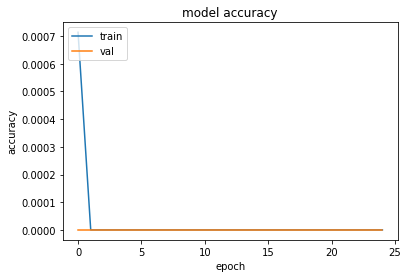

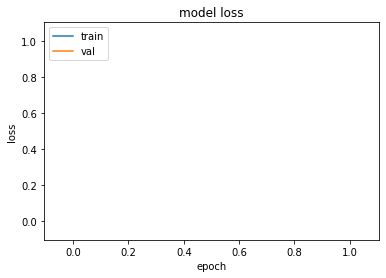

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
nn_kfold(df_raw_mean_75)

Training data shape: (16807, 78)
Val data shape: (4202, 78)
Test data shape: (10348, 78)
Input shape: 77
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 77, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 32)            96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 75, 32)            2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 32)            128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 74, 64)            4160      
_______________

4202/4202 [==============================] - 8s 2ms/step
------------------------------------------------------------------------
Score for val cnn: loss of nan;  accuracy of 0.0; precision of 0.0; recall of 0.0; AUC of 0.0;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


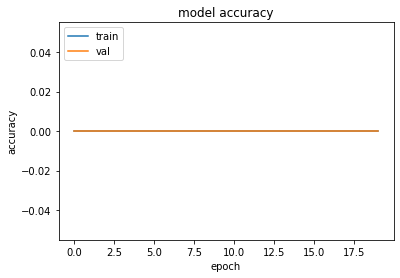

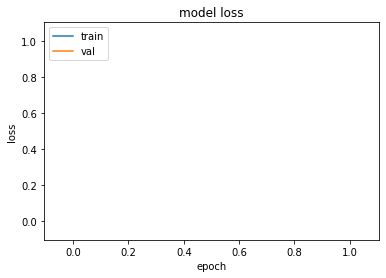

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
cnn(df_raw_mean_75)

Training data shape: (16807, 78)
Val data shape: (4202, 78)
Test data shape: (10348, 78)
Input shape: 77
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               15600     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
_______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 186us/step
------------------------------------------------------------------------
Score for fold 1: loss of nan;  accuracy of 0.0; precision of 0.0; recall of 0.0; AUC of 0.0;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 185us/step
------------------------------------------------------------------------
Score for fold 2: loss of nan;  accuracy of 0.0; precision of 0.0; recall of 0.0; AUC of 0.0;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 182us/step
------------------------------------------------------------------------
Score for fold 3: loss of nan;  accuracy of 0.0; precision of 0.0; recall of 0.0; AUC of 0.0;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


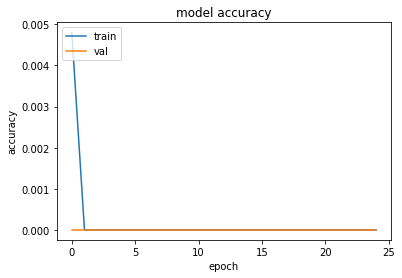

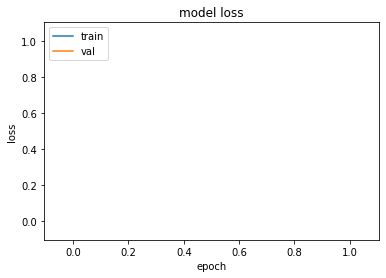

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
nn_kfold(df_raw_mean_75, balanced_batches=True)

Training data shape: (16807, 78)
Val data shape: (4202, 78)
Test data shape: (10348, 78)
Input shape: 77
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 77, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 76, 32)            96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 76, 32)            128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 75, 32)            2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 75, 32)            128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 74, 64)            4160      
_______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 24s 299ms/step - loss: nan - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/20
79/79 [==============================] - 16s 201ms/step - loss: nan - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 3/20
79/79 [==============================] - 16s 200ms/step - loss: nan - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 4/20
79/79 [==============================] - 16s 200ms/step - loss: nan - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - AU

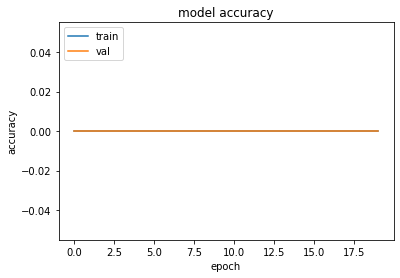

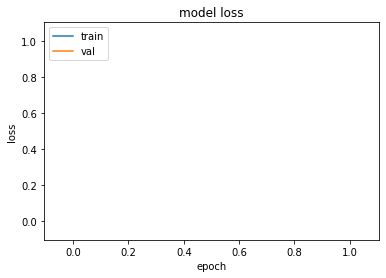

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
cnn(df_raw_mean_75, balanced_batches=True)

## Data with more features from NHANES

In [12]:
# read in normal mean_75 imputed more features data
df_raw_mean_75_OG =  pd.read_csv('df_mean_75_ext.csv')  # 112 columns
df_raw_mean_75_OG.head()


,SEQN,year,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,...,savings_5000,min_sedetary,oral_rec,lab_VitB12,bone_mineral_density,difficult_hearing,difficult_seeing,difficult_walking,difficult_errands,doc_COPD
0,31131.0,2005-2006,0.0,0.0,0.0,4.0,4.000000,4.0,44.0,0.0,...,0.0,358.089431,4.0,631.61531,1.112089,0.0,0.0,0.0,0.0,0.0
1,31132.0,2005-2006,0.0,0.0,0.0,3.0,5.000000,2.0,70.0,1.0,...,0.0,358.089431,4.0,631.61531,1.112089,0.0,0.0,0.0,0.0,0.0
2,31134.0,2005-2006,0.0,0.0,0.0,3.0,3.000000,2.0,73.0,1.0,...,0.0,358.089431,4.0,631.61531,1.112089,0.0,0.0,0.0,0.0,0.0
3,31139.0,2005-2006,0.0,0.0,0.0,2.0,3.389134,3.0,18.0,0.0,...,0.0,358.089431,4.0,631.61531,1.112089,0.0,0.0,0.0,0.0,0.0
4,31143.0,2005-2006,0.0,0.0,0.0,3.0,3.389134,3.0,19.0,1.0,...,0.0,358.089431,4.0,631.61531,1.112089,0.0,0.0,0.0,0.0,0.0


Training data shape: (16807, 164)
Val data shape: (4202, 164)
Test data shape: (10348, 164)
Input shape: 163
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 200)               32800     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
___________

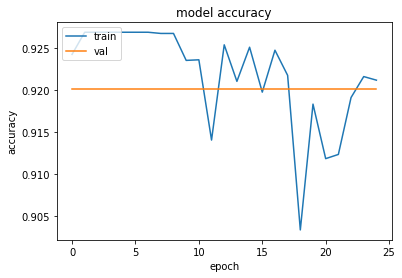

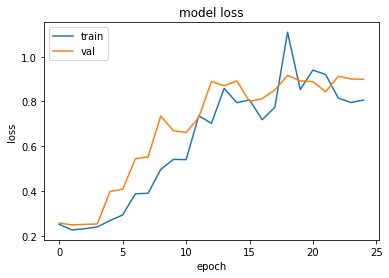

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
nn_kfold(df_raw_mean_75_OG)

Training data shape: (16807, 164)
Val data shape: (4202, 164)
Test data shape: (10348, 164)
Input shape: 163
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 163, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 162, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 162, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 161, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 161, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 160, 64)           4160      
__________

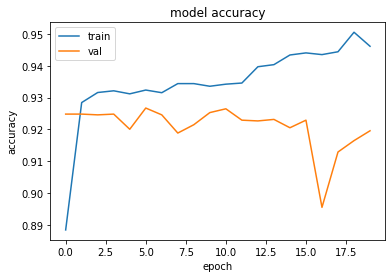

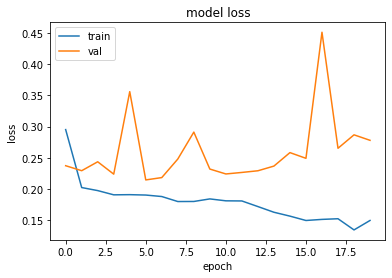

[[9347  234]
 [ 610  157]]
F1 score: 0.27115716753022456
Precision: 0.40153452685422
Recall: 0.2046936114732725
Accuracy: 0.9184383455740239
ROC AUC: 0.5901351368085493


In [18]:
cnn(df_raw_mean_75_OG)

Training data shape: (16807, 164)
Val data shape: (4202, 164)
Test data shape: (10348, 164)
Input shape: 163
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 200)               32800     
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_77 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_78 (Dropout)         (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 244us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.1555524790234246;  accuracy of 0.7328287959098816; precision of 0.7328287959098816; recall of 0.7328287959098816; AUC of 0.7579749822616577;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 202us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.725314493828223;  accuracy of 0.7008424997329712; precision of 0.7008424997329712; recall of 0.7008424997329712; AUC of 0.7777979373931885;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 307us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.5263659111281964;  accuracy of 0.7179780006408691; precision of 0.7179780006408691; recall of 0.7179780006408691; AUC of 0.7776541709899902;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


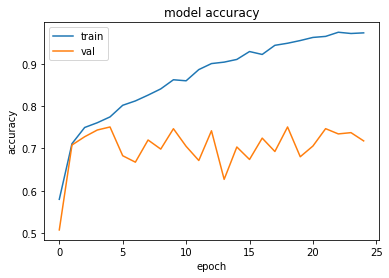

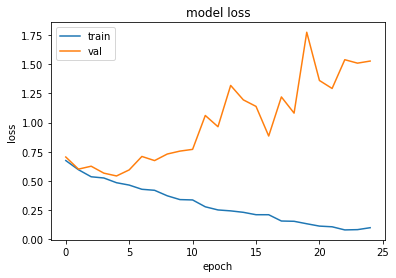

[[6743 2838]
 [ 224  543]]
F1 score: 0.2618129218900675
Precision: 0.160603371783496
Recall: 0.7079530638852672
Accuracy: 0.7040974101275609
ROC AUC: 0.7058709062250675


In [19]:
nn_kfold(df_raw_mean_75_OG, balanced_batches=True)

Training data shape: (16807, 164)
Val data shape: (4202, 164)
Test data shape: (10348, 164)
Input shape: 163
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 163, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 162, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 162, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 161, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 161, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 160, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 50s 628ms/step - loss: 0.7431 - accuracy: 0.6994 - precision: 0.6994 - recall: 0.6994 - AUC: 0.7596 - val_loss: 0.7366 - val_accuracy: 0.0947 - val_precision: 0.0947 - val_recall: 0.0947 - val_AUC: 0.1121
Epoch 2/20
79/79 [==============================] - 33s 415ms/step - loss: 0.5192 - accuracy: 0.7604 - precision: 0.7604 - recall: 0.7604 - AUC: 0.8363 - val_loss: 0.7858 - val_accuracy: 0.0909 - val_precision: 0.0909 - val_recall: 0.0909 - val_AUC: 0.1185
Epoch 3/20
79/79 [==============================] - 32s 407ms/step - loss: 0.4648 - accuracy: 0.7819 - precision: 0.7819 - recall: 0.7819 - AUC: 0.8623 - val_loss: 0.9268 - val_accuracy: 0.0785 - val_precision: 0.0785 - val_recall: 0.0785 - val_AUC: 0.1173
Epoch 4/20
79/79 [==============================] - 31s 393ms/step - loss: 0.4431 - accuracy: 0.8039 - precision: 0.8039 - recall: 0.8039 - AUC: 0.8749 - val_loss: 0.7699 - val_accuracy: 0.4426 - val_precision: 0.4426 - val_recal

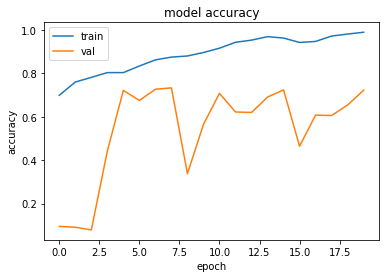

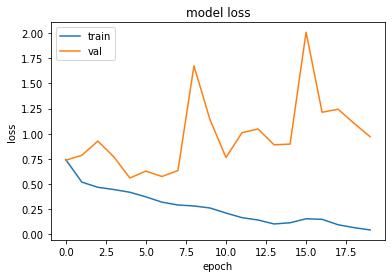

[[6945 2636]
 [ 248  519]]
F1 score: 0.26466088730239673
Precision: 0.16450079239302695
Recall: 0.6766623207301173
Accuracy: 0.7212988017008117
ROC AUC: 0.700767231756354


In [20]:
cnn(df_raw_mean_75_OG, balanced_batches=True)

## Subset of NHANES features 1/3

In [13]:
subset1 = ['depressed','tried_lose_weight', 'triglyceride', 'tot_cholesterol', 'glycohemoglobin', 
           'herpes_2', 'HIV', 'rbc_folate', 'serum_folate', 'fasting_glucose', 'lab_VitD', 
           'systolic_BP', 'diastolic_BP', 'pulse', 'BMI', 'waist_C', 'VitD', '#meals_fast_food', 
           'monthly_income', 'savings_5000', 'min_sedetary', 'doc_HPV', 'oral_rec', 
           'difficult_remembering', 'prob_smell', 'prob_tatse', 'persistent_cold', 
           'nasal_congestion', 'serum_selenium', 'serum_zinc', 'serum_creatinine', 
           'lab_VitB12', 'bone_mineral_density', 'difficult_hearing', 'difficult_seeing', 
           'difficult_walking', 'difficult_errands']
s1 = []
for s in subset1:
    if s in df_raw_mean_75_OG.columns:
        s1.append(s)

df_mean_75_sub1 = df_raw_mean_75_OG[s1]


Training data shape: (16807, 31)
Val data shape: (4202, 31)
Test data shape: (10348, 31)
Input shape: 30
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 200)               6200      
_________________________________________________________________
dropout_151 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_152 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_153 (Dropout)        (None, 100)               0         
______________

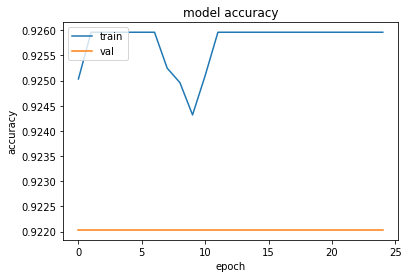

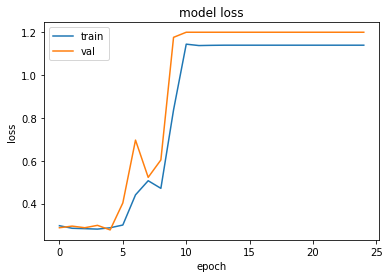

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
nn_kfold(df_mean_75_sub1)

Training data shape: (16807, 31)
Val data shape: (4202, 31)
Test data shape: (10348, 31)
Input shape: 30
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 30, 1)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_31 (Batc (None, 29, 32)            128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 28, 32)            2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 28, 32)            128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 27, 64)            4160      
______________

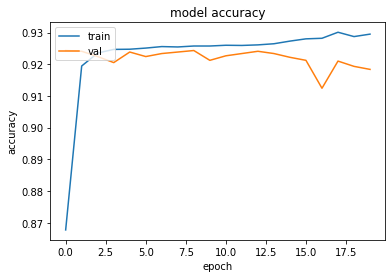

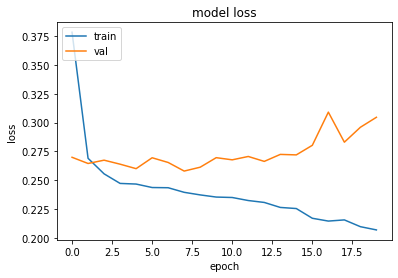

[[9511   70]
 [ 734   33]]
F1 score: 0.07586206896551724
Precision: 0.32038834951456313
Recall: 0.04302477183833116
Accuracy: 0.9223038268264399
ROC AUC: 0.5178593225646096


In [33]:
cnn(df_mean_75_sub1)

Training data shape: (16807, 31)
Val data shape: (4202, 31)
Test data shape: (10348, 31)
Input shape: 30
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 200)               6200      
_________________________________________________________________
dropout_176 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_177 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_206 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_178 (Dropout)        (None, 100)               0         
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 269us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.7243191145853062;  accuracy of 0.5923175811767578; precision of 0.5923175811767578; recall of 0.5923175811767578; AUC of 0.6304195523262024;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 241us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.7374709507116127;  accuracy of 0.6838497519493103; precision of 0.6838497519493103; recall of 0.6838497519493103; AUC of 0.6755842566490173;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 246us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.694139146683949;  accuracy of 0.6689990162849426; precision of 0.6689990162849426; recall of 0.6689990162849426; AUC of 0.710287868976593;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


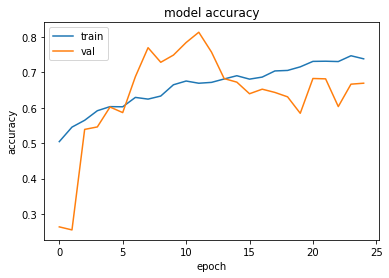

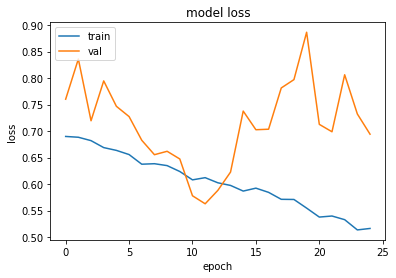

[[6518 3063]
 [ 409  358]]
F1 score: 0.17096466093600765
Precision: 0.10464776381175095
Recall: 0.4667535853976532
Accuracy: 0.6644762272902976
ROC AUC: 0.5735291776273309


In [34]:
nn_kfold(df_mean_75_sub1, balanced_batches=True)

Training data shape: (16807, 31)
Val data shape: (4202, 31)
Test data shape: (10348, 31)
Input shape: 30
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 30, 1)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_36 (Batc (None, 29, 32)            128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 28, 32)            2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 28, 32)            128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 27, 64)            4160      
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 20s 251ms/step - loss: 0.8890 - accuracy: 0.5748 - precision: 0.5748 - recall: 0.5748 - AUC: 0.5997 - val_loss: 0.7816 - val_accuracy: 0.0980 - val_precision: 0.0980 - val_recall: 0.0980 - val_AUC: 0.0940
Epoch 2/20
79/79 [==============================] - 9s 108ms/step - loss: 0.6451 - accuracy: 0.6482 - precision: 0.6482 - recall: 0.6482 - AUC: 0.7019 - val_loss: 1.0055 - val_accuracy: 0.0812 - val_precision: 0.0812 - val_recall: 0.0812 - val_AUC: 0.0874
Epoch 3/20
79/79 [==============================] - 9s 111ms/step - loss: 0.5856 - accuracy: 0.6957 - precision: 0.6957 - recall: 0.6957 - AUC: 0.7591 - val_loss: 0.7364 - val_accuracy: 0.3836 - val_precision: 0.3836 - val_recall: 0.3836 - val_AUC: 0.3425
Epoch 4/20
79/79 [==============================] - 8s 107ms/step - loss: 0.5434 - accuracy: 0.7173 - precision: 0.7173 - recall: 0.7173 - AUC: 0.7962 - val_loss: 0.7438 - val_accuracy: 0.4322 - val_precision: 0.4322 - val_recall: 

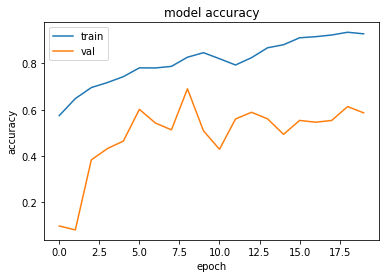

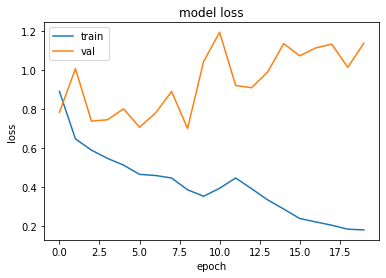

[[5680 3901]
 [ 361  406]]
F1 score: 0.1600315333070556
Precision: 0.09426514975621082
Recall: 0.529335071707953
Accuracy: 0.5881329725550831
ROC AUC: 0.5610875337665118


In [35]:
cnn(df_mean_75_sub1, balanced_batches=True)

## Subset intuitively chosen 1/2

In [14]:
subset2 = ['depressed', 'race_ethnicity', 'edu_level', 'age', 'gender', 'annual_HI',
              'marital_status', 'special_diet', 'protein', 'carb','sugar', 'fiber', 'fat', 
               'diet_chol', 'VitB6', 'folate', 'VitB12', 'doc_diabetes','how_healthy_diet', 
               'used_CMH', 'gen_health_cond','healthcare_past_yr', 'run_out_food', 'afford_balanced_meals',
              'food_security_cat', 'food_stamps', 'doc_asthma','doc_overweight', 'doc_arthritis', 
               'doc_CHD','doc_heart_attack', 'doc_stroke', 'doc_chronic_bronchitis',
               'doc_liver_condition', 'doc_thyroid_problem', 'doc_cancer','anemia', 'doc_kidney',
               'work_type', 'embarassed_mouth', 'lab_B12', 'vigorous_activity','moderate_activity', 
               'hours_TV', 'hours_computer','manage_$_difficult', 'doc_sleeping_disorder','hrs_sleep',
              'smoked_5days', 'sexual_orientation','alcoholic', 'consider_weight','triglyceride', 'tot_cholesterol',
              'rbc_folate','fasting_glucose', 'lab_VitD','BMI','min_sedetary','difficult_remembering',
              'persistent_cold','lab_VitB12','difficult_errands', 'doc_COPD']

s2 = []
for s in subset2:
    if s in df_raw_mean_75_OG.columns:
        s2.append(s)

df_mean_75_sub2 = df_raw_mean_75_OG[s2]

Training data shape: (16807, 102)
Val data shape: (4202, 102)
Test data shape: (10348, 102)
Input shape: 101
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               20400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



7003/7003 [==============================] - 2s 357us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.9282784872049606;  accuracy of 0.7439668774604797; precision of 0.7439668774604797; recall of 0.7439668774604797; AUC of 0.8390571475028992;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 270us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.174337622762901;  accuracy of 0.7715265154838562; precision of 0.7715265154838562; recall of 0.7715265154838562; AUC of 0.8329854607582092;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 145us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.2228315850759972;  accuracy of 0.7628159523010254; precision of 0.7628159523010254; recall of 0.7628159523010254; AUC of 0.817490816116333;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


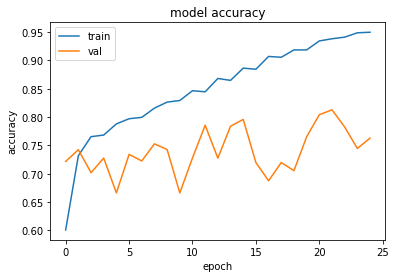

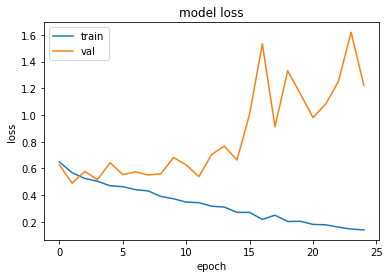

[[7288 2293]
 [ 256  511]]
F1 score: 0.28619434332119853
Precision: 0.18223965763195435
Recall: 0.666232073011734
Accuracy: 0.7536722071897951
ROC AUC: 0.7134521183344861


In [14]:
nn_kfold(df_mean_75_sub2, balanced_batches=True)

Training data shape: (16807, 102)
Val data shape: (4202, 102)
Test data shape: (10348, 102)
Input shape: 101
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 101, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 99, 32)            2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 99, 32)            128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 98, 64)            4160      
___________

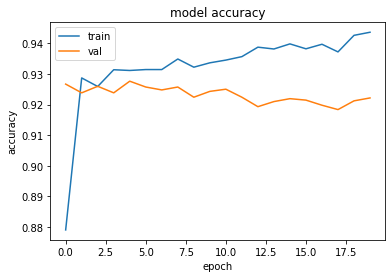

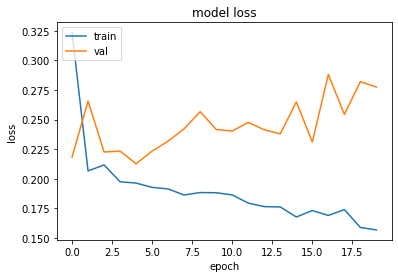

[[9420  161]
 [ 647  120]]
F1 score: 0.22900763358778628
Precision: 0.42704626334519574
Recall: 0.15645371577574968
Accuracy: 0.9219172787011983
ROC AUC: 0.5698248121723963


In [15]:
cnn(df_mean_75_sub2)

Training data shape: (16807, 102)
Val data shape: (4202, 102)
Test data shape: (10348, 102)
Input shape: 101
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               20400     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 213us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.8741547512221672;  accuracy of 0.597743809223175; precision of 0.597743809223175; recall of 0.597743809223175; AUC of 0.6284616589546204;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 252us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.6809263296779626;  accuracy of 0.7241182327270508; precision of 0.7241182327270508; recall of 0.7241182327270508; AUC of 0.7506799697875977;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 222us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.5025148764348415;  accuracy of 0.6668570637702942; precision of 0.6668570637702942; recall of 0.6668570637702942; AUC of 0.7357685565948486;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


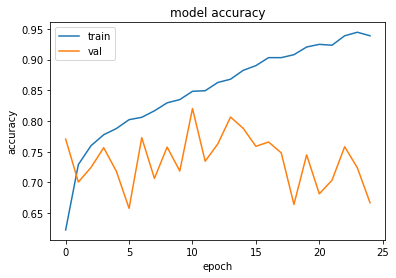

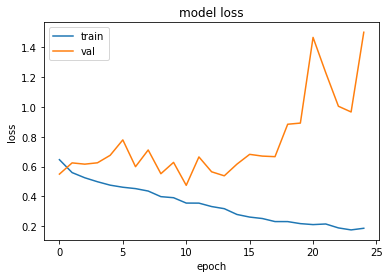

[[6235 3346]
 [ 173  594]]
F1 score: 0.25239005736137665
Precision: 0.15076142131979695
Recall: 0.7744458930899609
Accuracy: 0.6599342868187089
ROC AUC: 0.7126065181972088


In [16]:
nn_kfold(df_mean_75_sub2, balanced_batches=True)

Training data shape: (16807, 102)
Val data shape: (4202, 102)
Test data shape: (10348, 102)
Input shape: 101
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 101, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 99, 32)            2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 99, 32)            128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 98, 64)            4160      
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 38s 487ms/step - loss: 0.7167 - accuracy: 0.6986 - precision: 0.6986 - recall: 0.6986 - AUC: 0.7609 - val_loss: 0.7228 - val_accuracy: 0.2235 - val_precision: 0.2235 - val_recall: 0.2235 - val_AUC: 0.1776
Epoch 2/20
79/79 [==============================] - 28s 358ms/step - loss: 0.5045 - accuracy: 0.7568 - precision: 0.7568 - recall: 0.7568 - AUC: 0.8382 - val_loss: 0.5638 - val_accuracy: 0.9024 - val_precision: 0.9024 - val_recall: 0.9024 - val_AUC: 0.9554
Epoch 3/20
79/79 [==============================] - 27s 341ms/step - loss: 0.4699 - accuracy: 0.7847 - precision: 0.7847 - recall: 0.7847 - AUC: 0.8598 - val_loss: 0.7969 - val_accuracy: 0.3229 - val_precision: 0.3229 - val_recall: 0.3229 - val_AUC: 0.2710
Epoch 4/20
79/79 [==============================] - 25s 312ms/step - loss: 0.4242 - accuracy: 0.7975 - precision: 0.7975 - recall: 0.7975 - AUC: 0.8851 - val_loss: 0.6585 - val_accuracy: 0.6337 - val_precision: 0.6337 - val_recal

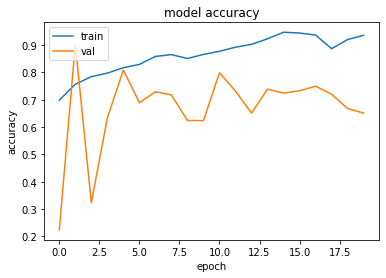

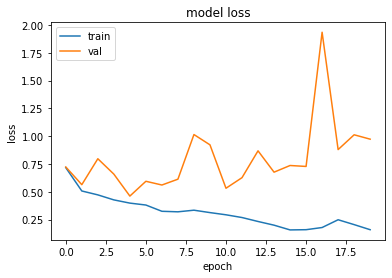

[[6249 3332]
 [ 196  571]]
F1 score: 0.24453961456102788
Precision: 0.14629771970279273
Recall: 0.7444589308996089
Accuracy: 0.6590645535369154
ROC AUC: 0.6983436497729439


In [17]:
cnn(df_mean_75_sub2, balanced_batches=True)

## Created new features (categorical)

In [13]:
df_raw_mean_75_ext =  pd.read_csv('df_mean_75_feature_ext.csv')

df_ext_square = df_raw_mean_75_ext[df_raw_mean_75_ext.columns.drop(list(df_raw_mean_75_ext.filter(regex='_2')))]

Training data shape: (16807, 176)
Val data shape: (4202, 176)
Test data shape: (10348, 176)
Input shape: 175
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 200)               35200     
_________________________________________________________________
dropout_101 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_102 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_103 (Dropout)        (None, 100)               0         
__________

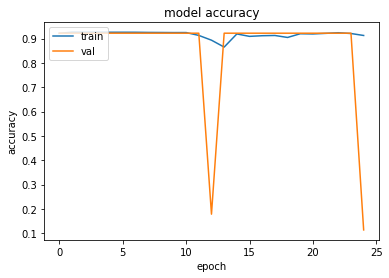

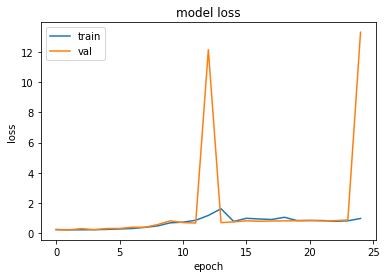

[[ 541 9040]
 [ 109  658]]
F1 score: 0.125752508361204
Precision: 0.06784904103938956
Recall: 0.8578878748370273
Accuracy: 0.11586780054116738
ROC AUC: 0.45717689848729565


In [25]:
nn_kfold(df_ext_square)

Training data shape: (16807, 176)
Val data shape: (4202, 176)
Test data shape: (10348, 176)
Input shape: 175
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 175, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 174, 32)           96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 174, 32)           128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 173, 32)           2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 173, 32)           128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 172, 64)           4160      
__________

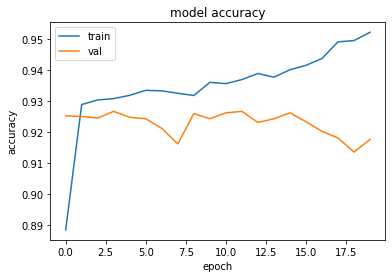

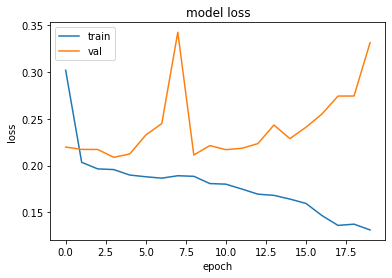

[[9326  255]
 [ 603  164]]
F1 score: 0.27655986509274877
Precision: 0.3914081145584726
Recall: 0.2138200782268579
Accuracy: 0.9170854271356784
ROC AUC: 0.5936024511789755


In [26]:
cnn(df_ext_square)

Training data shape: (16807, 176)
Val data shape: (4202, 176)
Test data shape: (10348, 176)
Input shape: 175
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 200)               35200     
_________________________________________________________________
dropout_126 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_127 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_128 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 293us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.4515510353721348;  accuracy of 0.7659574747085571; precision of 0.7659574747085571; recall of 0.7659574747085571; AUC of 0.8181222081184387;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 228us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.4005082882797142;  accuracy of 0.7722404599189758; precision of 0.7722404599189758; recall of 0.7722404599189758; AUC of 0.8362793326377869;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 245us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.6931083736190895;  accuracy of 0.7598172426223755; precision of 0.7598172426223755; recall of 0.7598172426223755; AUC of 0.7863579392433167;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


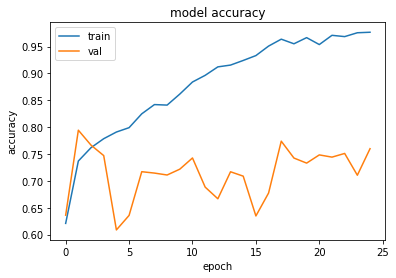

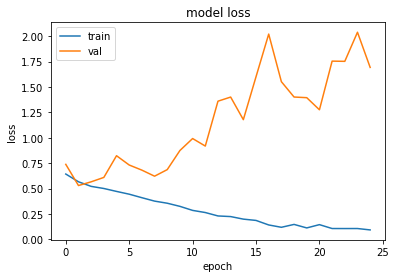

[[7212 2369]
 [ 270  497]]
F1 score: 0.27360308285163776
Precision: 0.17341242149337055
Recall: 0.6479791395045632
Accuracy: 0.7449748743718593
ROC AUC: 0.7003594685102401


In [27]:
nn_kfold(df_ext_square, balanced_batches=True)

Training data shape: (16807, 176)
Val data shape: (4202, 176)
Test data shape: (10348, 176)
Input shape: 175
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 175, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 174, 32)           96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 174, 32)           128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 173, 32)           2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 173, 32)           128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 172, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 49s 614ms/step - loss: 0.6522 - accuracy: 0.7176 - precision: 0.7176 - recall: 0.7176 - AUC: 0.7838 - val_loss: 0.6794 - val_accuracy: 0.6528 - val_precision: 0.6528 - val_recall: 0.6528 - val_AUC: 0.7021
Epoch 2/20
79/79 [==============================] - 42s 533ms/step - loss: 0.4902 - accuracy: 0.7640 - precision: 0.7640 - recall: 0.7640 - AUC: 0.8463 - val_loss: 0.6308 - val_accuracy: 0.8046 - val_precision: 0.8046 - val_recall: 0.8046 - val_AUC: 0.8693
Epoch 3/20
79/79 [==============================] - 38s 485ms/step - loss: 0.4313 - accuracy: 0.7999 - precision: 0.7999 - recall: 0.7999 - AUC: 0.8813 - val_loss: 0.5909 - val_accuracy: 0.7946 - val_precision: 0.7946 - val_recall: 0.7946 - val_AUC: 0.8620
Epoch 4/20
79/79 [==============================] - 36s 457ms/step - loss: 0.4085 - accuracy: 0.8099 - precision: 0.8099 - recall: 0.8099 - AUC: 0.8932 - val_loss: 0.6250 - val_accuracy: 0.6728 - val_precision: 0.6728 - val_recal

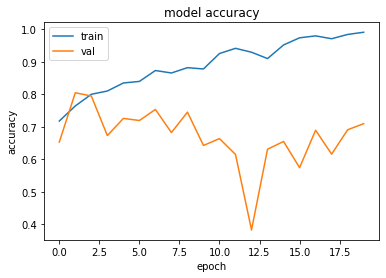

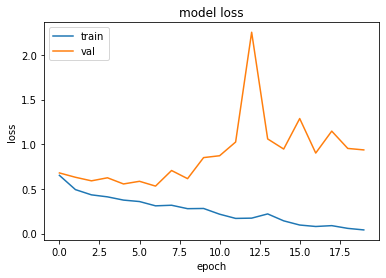

[[6911 2670]
 [ 266  501]]
F1 score: 0.2544438801422042
Precision: 0.15799432355723747
Recall: 0.6531942633637549
Accuracy: 0.716273676072671
ROC AUC: 0.6872588580152456


In [28]:
cnn(df_ext_square, balanced_batches=True)

## Created + log(cont)

In [14]:
df_created_log = df_ext_square.copy()

cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_log[str(var) + '_log'] = (df_created_log[var]-df_created_log[var].min()+1).transform(np.log)


df_created_log.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_log,monthly_income_log,min_sedetary_log,lab_VitB12_log,bone_mineral_density_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,0.693147,1.098612,4.859812,0.352821,5.708488
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,1.098612,1.098612,4.691348,0.159630,6.703706
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,0.693147,0.693147,4.691348,0.189621,5.668580
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,1.098612,2.197225,4.442651,0.260884,5.734725
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,0.000000,1.945910,4.394449,0.301325,6.287247


Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               45000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

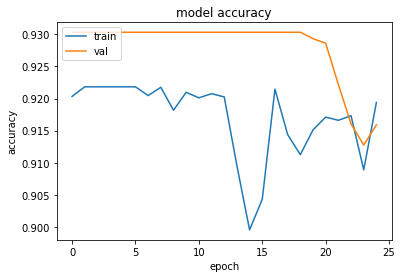

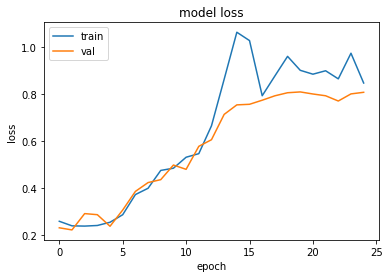

[[9297  284]
 [ 607  160]]
F1 score: 0.2642444260941371
Precision: 0.36036036036036034
Recall: 0.20860495436766624
Accuracy: 0.9138964051024353
ROC AUC: 0.5894814772882064


In [16]:
nn_kfold(df_created_log)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 223, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 222, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 221, 64)           4160      
___________

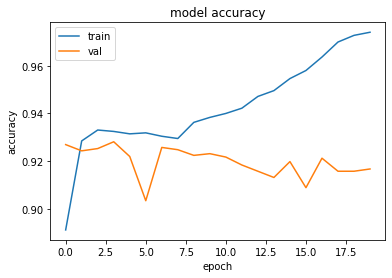

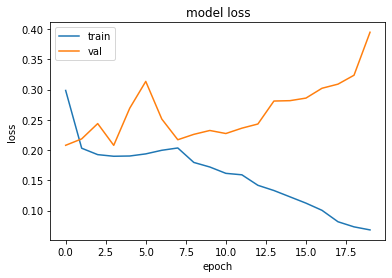

[[9357  224]
 [ 606  161]]
F1 score: 0.2795138888888889
Precision: 0.41818181818181815
Recall: 0.20990873533246415
Accuracy: 0.9197912640123695
ROC AUC: 0.5932645649316532


In [17]:
cnn(df_created_log)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               45000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



7003/7003 [==============================] - 1s 169us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.988459418284013;  accuracy of 0.7599599957466125; precision of 0.7599599957466125; recall of 0.7599599957466125; AUC of 0.8382929563522339;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 182us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.3197821858575067;  accuracy of 0.7031272053718567; precision of 0.7031272053718567; recall of 0.7031272053718567; AUC of 0.7493913173675537;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 178us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.9961364701120032;  accuracy of 0.6691417694091797; precision of 0.6691417694091797; recall of 0.6691417694091797; AUC of 0.6994488835334778;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


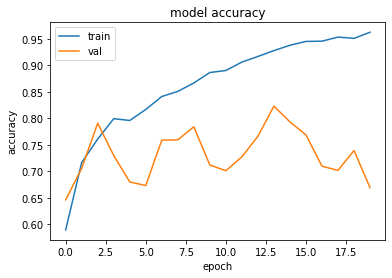

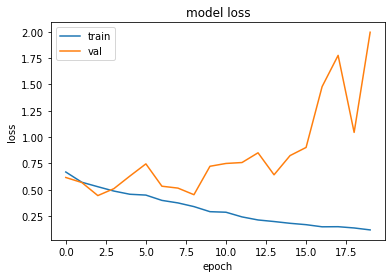

[[6225 3356]
 [ 174  593]]
F1 score: 0.25148430873621713
Precision: 0.1501645986325652
Recall: 0.7731421121251629
Accuracy: 0.6588712794742946
ROC AUC: 0.7114327615213019


In [15]:
nn_kfold(df_created_log, balanced_batches=True)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 223, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 222, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 221, 64)           4160      
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/15
79/79 [==============================] - 48s 602ms/step - loss: 0.7050 - accuracy: 0.7069 - precision: 0.7069 - recall: 0.7069 - AUC: 0.7658 - val_loss: 0.5237 - val_accuracy: 0.9255 - val_precision: 0.9255 - val_recall: 0.9255 - val_AUC: 0.9656
Epoch 2/15
79/79 [==============================] - 40s 504ms/step - loss: 0.4859 - accuracy: 0.7680 - precision: 0.7680 - recall: 0.7680 - AUC: 0.8491 - val_loss: 0.5952 - val_accuracy: 0.8451 - val_precision: 0.8451 - val_recall: 0.8451 - val_AUC: 0.9105
Epoch 3/15
79/79 [==============================] - 40s 504ms/step - loss: 0.4510 - accuracy: 0.7919 - precision: 0.7919 - recall: 0.7919 - AUC: 0.8703 - val_loss: 0.6253 - val_accuracy: 0.6966 - val_precision: 0.6966 - val_recall: 0.6966 - val_AUC: 0.7531
Epoch 4/15
79/79 [==============================] - 40s 501ms/step - loss: 0.4125 - accuracy: 0.8135 - precision: 0.8135 - recall: 0.8135 - AUC: 0.8927 - val_loss: 0.6265 - val_accuracy: 0.6659 - val_precision: 0.6659 - val_recal

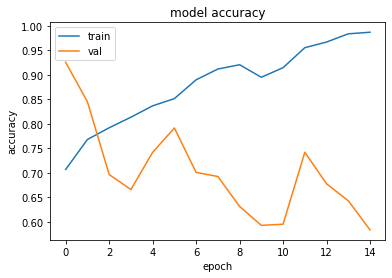

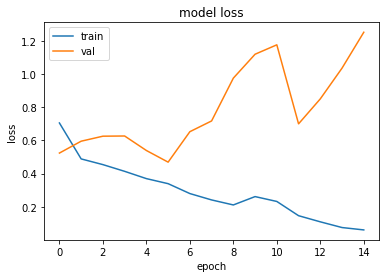

[[5569 4012]
 [ 162  605]]
F1 score: 0.224739970282318
Precision: 0.13103747021875678
Recall: 0.788787483702738
Accuracy: 0.5966370313103981
ROC AUC: 0.6850210250159656


In [16]:
cnn(df_created_log, balanced_batches=True)

## Created + sqrt

In [15]:
df_created_sqrt = df_ext_square.copy()

# cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_sqrt[str(var) + '_sqrt'] = (df_created_sqrt[var]-df_created_sqrt[var].min()+1).transform(np.sqrt)


df_created_sqrt.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_sqrt,monthly_income_sqrt,min_sedetary_sqrt,lab_VitB12_sqrt,bone_mineral_density_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.000000,2.645751,9.000000,1.162604,23.187734


Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               45000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
___________

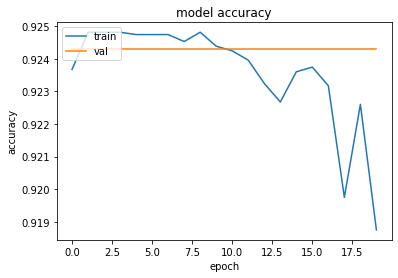

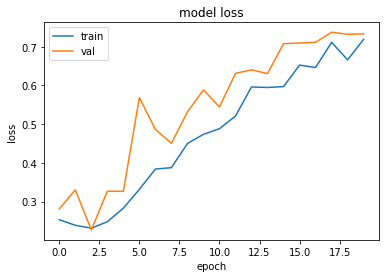

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
nn_kfold(df_created_sqrt)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 223, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 222, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 221, 64)           4160      
___________

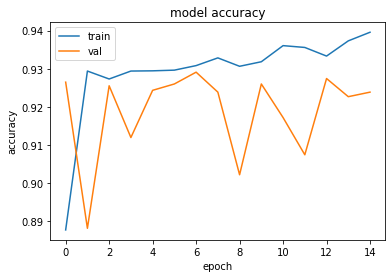

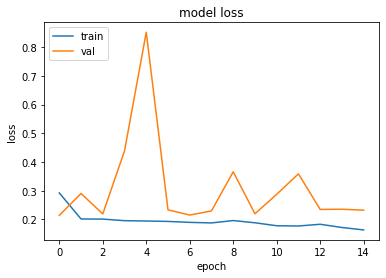

[[9403  178]
 [ 612  155]]
F1 score: 0.2818181818181818
Precision: 0.46546546546546547
Recall: 0.20208604954367665
Accuracy: 0.9236567452647855
ROC AUC: 0.5917538065273962


In [19]:
cnn(df_created_sqrt)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 200)               45000     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 230us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.720327663128842;  accuracy of 0.7622447609901428; precision of 0.7622447609901428; recall of 0.7622447609901428; AUC of 0.7899264097213745;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 206us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.3497480066200844;  accuracy of 0.708125114440918; precision of 0.708125114440918; recall of 0.708125114440918; AUC of 0.7643399834632874;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 216us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.889517169568635;  accuracy of 0.674282431602478; precision of 0.674282431602478; recall of 0.674282431602478; AUC of 0.6791163682937622;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


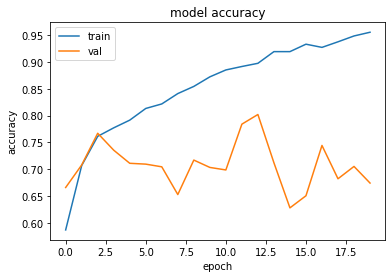

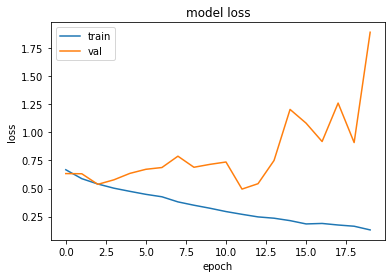

[[6362 3219]
 [ 200  567]]
F1 score: 0.2490665495277839
Precision: 0.14976228209191758
Recall: 0.7392438070404173
Accuracy: 0.6695979899497487
ROC AUC: 0.7016331758299884


In [20]:
nn_kfold(df_created_sqrt, balanced_batches=True)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 223, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 222, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 221, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/15
79/79 [==============================] - 48s 608ms/step - loss: 0.7074 - accuracy: 0.7061 - precision: 0.7061 - recall: 0.7061 - AUC: 0.7678 - val_loss: 0.5650 - val_accuracy: 0.9236 - val_precision: 0.9236 - val_recall: 0.9236 - val_AUC: 0.9667
Epoch 2/15
79/79 [==============================] - 40s 507ms/step - loss: 0.5148 - accuracy: 0.7584 - precision: 0.7584 - recall: 0.7584 - AUC: 0.8335 - val_loss: 0.7023 - val_accuracy: 0.5055 - val_precision: 0.5055 - val_recall: 0.5055 - val_AUC: 0.4812
Epoch 3/15
79/79 [==============================] - 40s 503ms/step - loss: 0.4572 - accuracy: 0.7819 - precision: 0.7819 - recall: 0.7819 - AUC: 0.8661 - val_loss: 0.6324 - val_accuracy: 0.6954 - val_precision: 0.6954 - val_recall: 0.6954 - val_AUC: 0.7505
Epoch 4/15
79/79 [==============================] - 40s 503ms/step - loss: 0.4172 - accuracy: 0.8039 - precision: 0.8039 - recall: 0.8039 - AUC: 0.8891 - val_loss: 0.5899 - val_accuracy: 0.7449 - val_precision: 0.7449 - val_recal

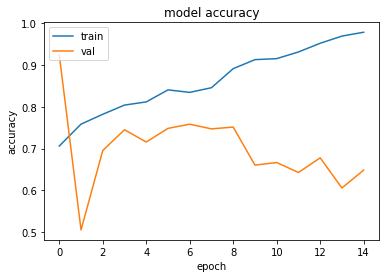

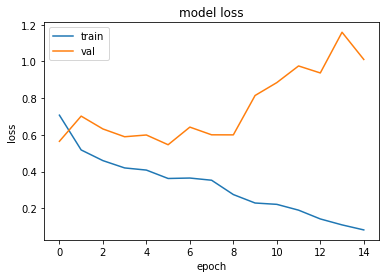

[[6139 3442]
 [ 199  568]]
F1 score: 0.23780615449026588
Precision: 0.14164588528678304
Recall: 0.7405475880052151
Accuracy: 0.6481445689988403
ROC AUC: 0.6906474501971592


In [21]:
cnn(df_created_sqrt, balanced_batches=True)

## Created + poly

In [16]:
df_created_poly = df_ext_square.copy()

# 1+5x+8x2
for var in cont:
    df_created_poly[str(var) + '_poly'] = (1+(5*df_created_poly[var])+(8*np.power(df_created_poly[var],2)))


df_created_poly.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_poly,monthly_income_poly,min_sedetary_poly,lab_VitB12_poly,bone_mineral_density_poly,#_chronic_condition_poly,hours_screen_poly,combined_BP_poly,people_per_rooms_poly,diet_tot_VitB_poly
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,14.0,43.0,381283.0,5.500000,7.234965e+05
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,43.0,43.0,314623.0,2.750000,5.310339e+06
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,14.0,14.0,314623.0,3.081633,6.678700e+05
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,43.0,553.0,243079.0,4.000000,7.625658e+05
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,1.0,319.0,232051.0,4.612245,2.306810e+06


Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               45000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

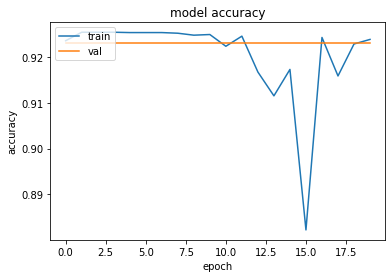

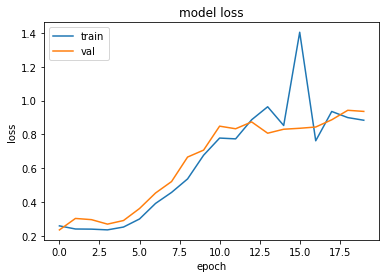

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
nn_kfold(df_created_poly)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 223, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 222, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 221, 64)           4160      
___________

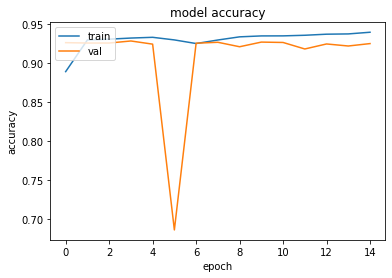

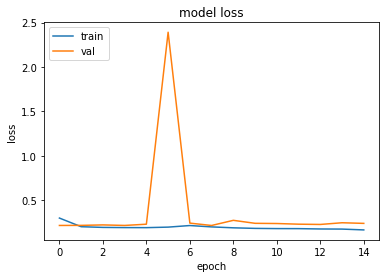

In [ ]:
cnn(df_created_poly)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               45000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



7003/7003 [==============================] - 1s 201us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.7534986286695797;  accuracy of 0.6565757393836975; precision of 0.6565757393836975; recall of 0.6565757393836975; AUC of 0.692594587802887;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 195us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.6709643956100908;  accuracy of 0.7486791610717773; precision of 0.7486791610717773; recall of 0.7486791610717773; AUC of 0.7694342136383057;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 196us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.7181663946749295;  accuracy of 0.6511495113372803; precision of 0.6511495113372803; recall of 0.6511495113372803; AUC of 0.7125266790390015;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


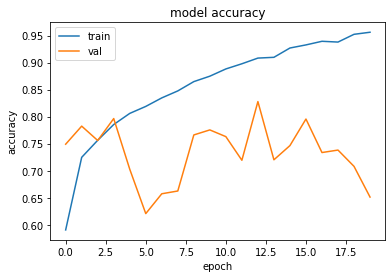

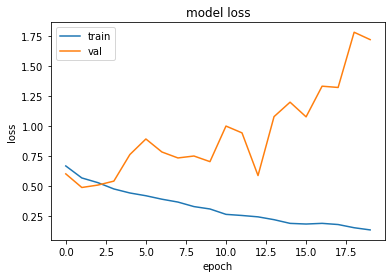

[[6058 3523]
 [ 183  584]]
F1 score: 0.23963890028723844
Precision: 0.14219625030435842
Recall: 0.7614080834419817
Accuracy: 0.6418631619636644
ROC AUC: 0.6968505817481279


In [17]:
nn_kfold(df_created_poly, balanced_batches=True)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 223, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 222, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 221, 64)           4160      
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/15
79/79 [==============================] - 58s 728ms/step - loss: 0.6629 - accuracy: 0.7093 - precision: 0.7093 - recall: 0.7093 - AUC: 0.7668 - val_loss: 0.5087 - val_accuracy: 0.9246 - val_precision: 0.9246 - val_recall: 0.9246 - val_AUC: 0.9653
Epoch 2/15
79/79 [==============================] - 40s 512ms/step - loss: 0.4966 - accuracy: 0.7660 - precision: 0.7660 - recall: 0.7660 - AUC: 0.8429 - val_loss: 0.6106 - val_accuracy: 0.8377 - val_precision: 0.8377 - val_recall: 0.8377 - val_AUC: 0.9094
Epoch 3/15
79/79 [==============================] - 40s 511ms/step - loss: 0.4720 - accuracy: 0.7724 - precision: 0.7724 - recall: 0.7724 - AUC: 0.8568 - val_loss: 0.6825 - val_accuracy: 0.5895 - val_precision: 0.5895 - val_recall: 0.5895 - val_AUC: 0.6058
Epoch 4/15
79/79 [==============================] - 41s 523ms/step - loss: 0.4344 - accuracy: 0.7947 - precision: 0.7947 - recall: 0.7947 - AUC: 0.8792 - val_loss: 0.6348 - val_accuracy: 0.6580 - val_precision: 0.6580 - val_recal

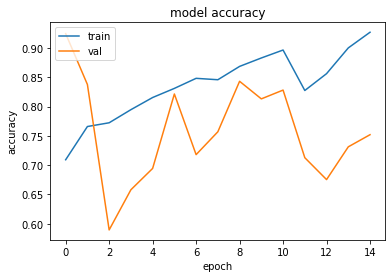

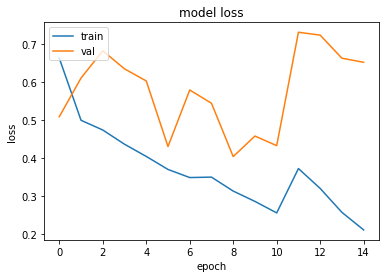

[[7249 2332]
 [ 258  509]]
F1 score: 0.2821507760532151
Precision: 0.17916226680746217
Recall: 0.6636245110821382
Accuracy: 0.7497100889060688
ROC AUC: 0.7101130592150071


In [18]:
cnn(df_created_poly, balanced_batches=True)

## Created + sin

In [19]:
df_created_sin = df_ext_square.copy()

# cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_sin[str(var) + '_sin'] = (df_created_sin[var]-df_created_sin[var].min()+1).transform(np.sin)


df_created_sin.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_sin,monthly_income_sin,min_sedetary_sin,lab_VitB12_sin,bone_mineral_density_sin,#_chronic_condition_sin,hours_screen_sin,combined_BP_sin,people_per_rooms_sin,diet_tot_VitB_sin
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.909297,0.141120,-0.193473,0.989109,-0.176958
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.141120,0.141120,0.816743,0.921947,-0.984074
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.909297,0.909297,0.816743,0.935189,0.561730
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.141120,0.412118,-0.176076,0.963042,0.999822
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.841471,0.656987,-0.629888,0.976083,-0.442744


Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               45000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
___________

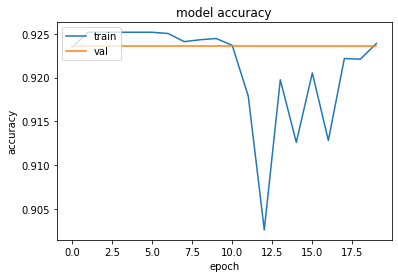

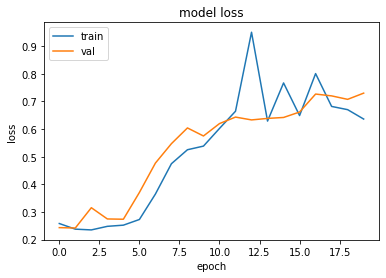

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
nn_kfold(df_created_sin)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 223, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 222, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 221, 64)           4160      
___________

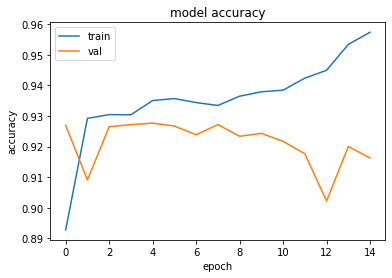

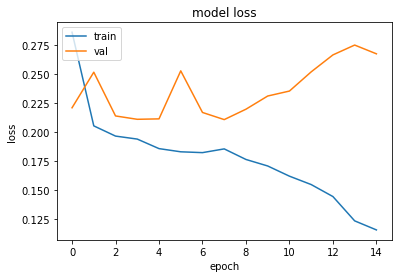

[[9191  390]
 [ 550  217]]
F1 score: 0.3158660844250364
Precision: 0.357495881383855
Recall: 0.28292046936114734
Accuracy: 0.9091611905682258
ROC AUC: 0.6211074531337623


In [21]:
cnn(df_created_sin)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 200)               45000     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 237us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.65922289287535;  accuracy of 0.7716692686080933; precision of 0.7716692686080933; recall of 0.7716692686080933; AUC of 0.8110622763633728;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 218us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.3035901996743147;  accuracy of 0.7548193335533142; precision of 0.7548193335533142; recall of 0.7548193335533142; AUC of 0.8168063759803772;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 238us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.9462585860144388;  accuracy of 0.7532486319541931; precision of 0.7532486319541931; recall of 0.7532486319541931; AUC of 0.7530147433280945;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


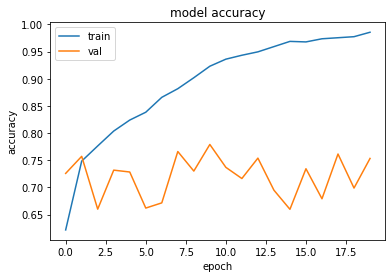

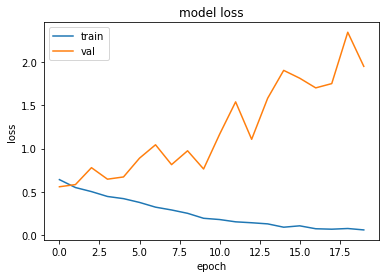

[[7269 2312]
 [ 262  505]]
F1 score: 0.2818080357142857
Precision: 0.1792687255946042
Recall: 0.6584093872229465
Accuracy: 0.7512562814070352
ROC AUC: 0.7085492296724272


In [22]:
nn_kfold(df_created_sin, balanced_batches=True)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 223, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 222, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 221, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/15
79/79 [==============================] - 48s 613ms/step - loss: 0.7350 - accuracy: 0.7029 - precision: 0.7029 - recall: 0.7029 - AUC: 0.7576 - val_loss: 0.4530 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250 - val_AUC: 0.9689
Epoch 2/15
79/79 [==============================] - 43s 540ms/step - loss: 0.4996 - accuracy: 0.7684 - precision: 0.7684 - recall: 0.7684 - AUC: 0.8441 - val_loss: 0.4396 - val_accuracy: 0.9253 - val_precision: 0.9253 - val_recall: 0.9253 - val_AUC: 0.9677
Epoch 3/15
79/79 [==============================] - 40s 509ms/step - loss: 0.4485 - accuracy: 0.7919 - precision: 0.7919 - recall: 0.7919 - AUC: 0.8712 - val_loss: 0.3883 - val_accuracy: 0.9205 - val_precision: 0.9205 - val_recall: 0.9205 - val_AUC: 0.9666
Epoch 4/15
79/79 [==============================] - 41s 516ms/step - loss: 0.3813 - accuracy: 0.8371 - precision: 0.8371 - recall: 0.8371 - AUC: 0.9093 - val_loss: 0.3747 - val_accuracy: 0.9058 - val_precision: 0.9058 - val_recal

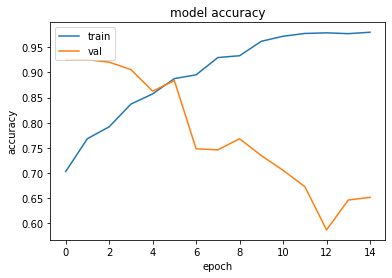

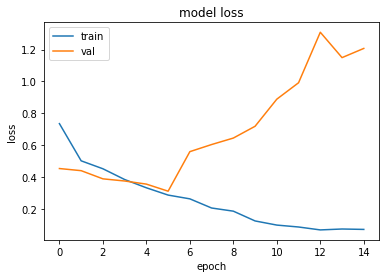

[[6054 3527]
 [ 177  590]]
F1 score: 0.2416052416052416
Precision: 0.14330823415108088
Recall: 0.7692307692307693
Accuracy: 0.6420564360262853
ROC AUC: 0.7005531781651184


In [23]:
cnn(df_created_sin, balanced_batches=True)

## subset of created columns - minimize correlation

In [22]:
subset_corr = ['depressed', 'broken_hip','edu_level', 'gender', 'marital_status', 'protein', 
       'sugar', 'fiber', 'fat', 'magnesium', 'iron', 'zinc', 'selenium', 'water', 
       'how_healthy_diet', 'gen_health_cond', 'healthcare_past_yr', 'health_insurance',
        'home_ownership', 'food_security_cat', 'work_type', 'hrs_worked_week',
       'embarassed_mouth', 'manage_$_difficult', 'doc_sleeping_disorder',
       'hrs_sleep', 'smoked_5days', 'sexual_orientation',  'consider_weight','triglyceride', 'tot_cholesterol', 'rbc_folate',
       'fasting_glucose', 'lab_VitD', 'pulse', 'BMI', 
       'monthly_income', 'oral_rec', 'difficult_remembering', 'prob_smell', 'prob_tatse',
       'persistent_cold',  'serum_selenium', 'serum_zinc', 'serum_creatinine', 'lab_VitB12',
        'doc_COPD', 'age_cat', 'not_enough_food', 'food_welfare', 'chronic_condition',
       '#_chronic_condition', 'active', 'hours_screen', 'limited',
       'taste_smell', 'difficult_everyday', 'combined_BP',
       'drugs_alcohol', 'people_per_rooms', 'sexuality', 'race_cat',
       'diet_tot_VitB']

s3 = []
for s in subset_corr:
    if s in df_ext_square.columns:
        s3.append(s)

df_min_corr = df_ext_square[s3]

In [38]:
df_min_corr.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,active,hours_screen,limited,difficult_everyday,combined_BP,drugs_alcohol,people_per_rooms,sexuality,race_cat,diet_tot_VitB
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,0.0,2.0,0.0,0.0,218.0,0.0,0.500000,0.0,3.0,300.415
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,1.0,2.0,0.0,0.0,198.0,0.0,0.250000,0.0,2.0,814.422
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,1.0,1.0,0.0,0.0,198.0,0.0,0.285714,0.0,2.0,288.623
3,0.0,0.0,4.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,1.0,8.0,0.0,0.0,174.0,0.0,0.375000,0.0,1.0,308.428
4,0.0,0.0,4.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,1.0,6.0,0.0,0.0,170.0,0.0,0.428571,0.0,2.0,536.671


Training data shape: (16807, 98)
Val data shape: (4202, 98)
Test data shape: (10348, 98)
Input shape: 97
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_233 (Dense)            (None, 200)               19600     
_________________________________________________________________
dropout_201 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_234 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_202 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_235 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_203 (Dropout)        (None, 100)               0         
______________

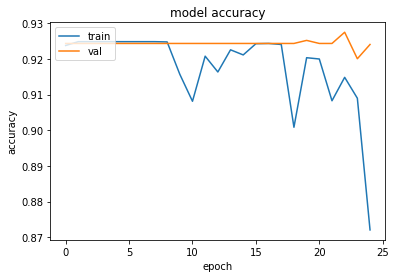

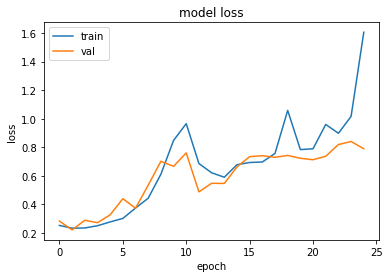

[[9443  138]
 [ 646  121]]
F1 score: 0.2358674463937622
Precision: 0.4671814671814672
Recall: 0.1577574967405476
Accuracy: 0.9242365674526478
ROC AUC: 0.5716769948998636


In [39]:
nn_kfold(df_min_corr)

Training data shape: (16807, 98)
Val data shape: (4202, 98)
Test data shape: (10348, 98)
Input shape: 97
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 97, 1)             0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 96, 32)            96        
_________________________________________________________________
batch_normalization_41 (Batc (None, 96, 32)            128       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 95, 32)            2080      
_________________________________________________________________
batch_normalization_42 (Batc (None, 95, 32)            128       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 94, 64)            4160      
______________

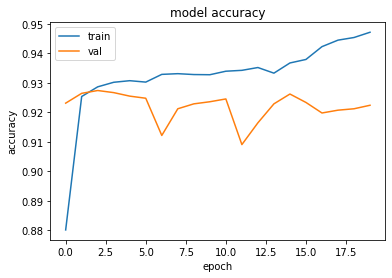

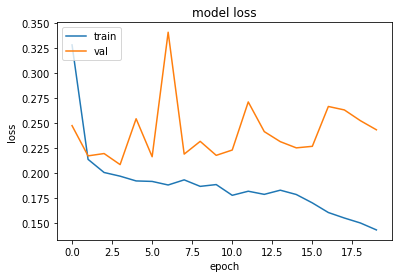

[[9406  175]
 [ 607  160]]
F1 score: 0.2903811252268602
Precision: 0.47761194029850745
Recall: 0.20860495436766624
Accuracy: 0.9244298415152686
ROC AUC: 0.5951698187974434


In [40]:
cnn(df_min_corr)

Training data shape: (16807, 98)
Val data shape: (4202, 98)
Test data shape: (10348, 98)
Input shape: 97
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_262 (Dense)            (None, 200)               19600     
_________________________________________________________________
dropout_226 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_227 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_228 (Dropout)        (None, 100)               0         
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 246us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.113784649125954;  accuracy of 0.7165500521659851; precision of 0.7165500521659851; recall of 0.7165500521659851; AUC of 0.7896662354469299;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 244us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.5942988831980236;  accuracy of 0.7309724688529968; precision of 0.7309724688529968; recall of 0.7309724688529968; AUC of 0.7692675590515137;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 246us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.8413860728600085;  accuracy of 0.8015136122703552; precision of 0.8015136122703552; recall of 0.8015136122703552; AUC of 0.8623518347740173;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


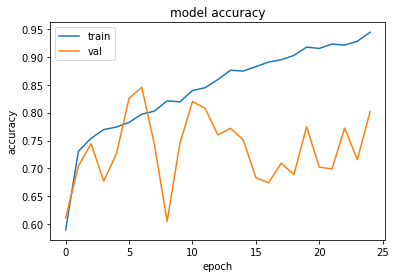

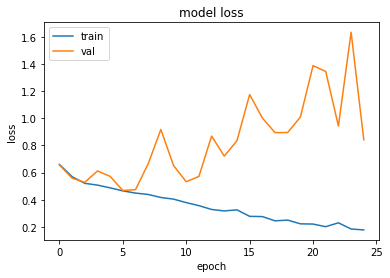

[[7668 1913]
 [ 296  471]]
F1 score: 0.29895271342430974
Precision: 0.19756711409395974
Recall: 0.6140808344198174
Accuracy: 0.7865287978353305
ROC AUC: 0.7072074143918312


In [41]:
nn_kfold(df_min_corr, balanced_batches=True)

Training data shape: (16807, 98)
Val data shape: (4202, 98)
Test data shape: (10348, 98)
Input shape: 97
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 97, 1)             0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 96, 32)            96        
_________________________________________________________________
batch_normalization_46 (Batc (None, 96, 32)            128       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 95, 32)            2080      
_________________________________________________________________
batch_normalization_47 (Batc (None, 95, 32)            128       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 94, 64)            4160      
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 32s 400ms/step - loss: 0.6773 - accuracy: 0.7100 - precision: 0.7100 - recall: 0.7100 - AUC: 0.7767 - val_loss: 0.9418 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1194
Epoch 2/20
79/79 [==============================] - 20s 257ms/step - loss: 0.5079 - accuracy: 0.7576 - precision: 0.7576 - recall: 0.7576 - AUC: 0.8368 - val_loss: 0.9184 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1171
Epoch 3/20
79/79 [==============================] - 20s 252ms/step - loss: 0.4707 - accuracy: 0.7815 - precision: 0.7815 - recall: 0.7815 - AUC: 0.8573 - val_loss: 0.7948 - val_accuracy: 0.2032 - val_precision: 0.2032 - val_recall: 0.2032 - val_AUC: 0.1612
Epoch 4/20
79/79 [==============================] - 20s 249ms/step - loss: 0.4452 - accuracy: 0.7911 - precision: 0.7911 - recall: 0.7911 - AUC: 0.8736 - val_loss: 0.8515 - val_accuracy: 0.2937 - val_precision: 0.2937 - val_recal

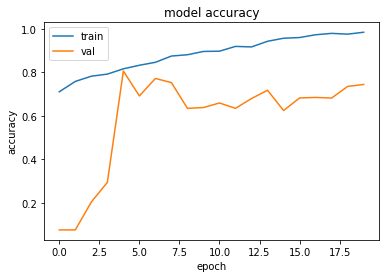

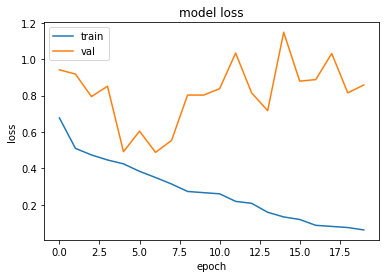

[[7167 2414]
 [ 268  499]]
F1 score: 0.27119565217391306
Precision: 0.17130106419498797
Recall: 0.6505867014341591
Accuracy: 0.7408194820255122
ROC AUC: 0.6993148516042521


In [42]:
cnn(df_min_corr, balanced_batches=True)

## Subset of created + log

In [23]:
df_sub_log = df_min_corr.copy()

cont, non_cont, cat_encode, = var_type(df_sub_log)

# log of all cont columns
for var in cont:
    df_sub_log[str(var) + '_log'] = (df_sub_log[var]-df_sub_log[var].min()+1).transform(np.log)


df_sub_log.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,lab_VitD_log,pulse_log,BMI_log,monthly_income_log,lab_VitB12_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,3.496811,3.135494,2.929592,2.651566,6.420997,0.693147,1.098612,4.859812,0.352821,5.708488
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,4.238589,3.295837,2.530517,2.651566,6.420997,1.098612,1.098612,4.691348,0.159630,6.703706
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,3.629925,2.708050,2.915064,2.651566,6.420997,0.693147,0.693147,4.691348,0.189621,5.668580
3,0.0,0.0,4.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,4.058998,3.496508,2.848971,2.651566,6.420997,1.098612,2.197225,4.442651,0.260884,5.734725
4,0.0,0.0,4.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,3.752089,3.496508,2.340844,2.651566,6.420997,0.000000,1.945910,4.394449,0.301325,6.287247


Training data shape: (16807, 125)
Val data shape: (4202, 125)
Test data shape: (10348, 125)
Input shape: 124
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 200)               25000     
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_77 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_78 (Dropout)         (None, 100)               0         
__________

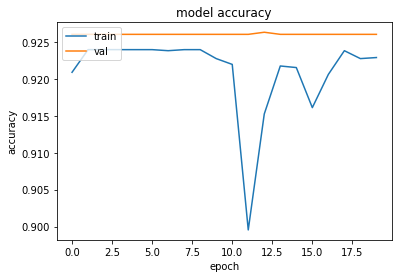

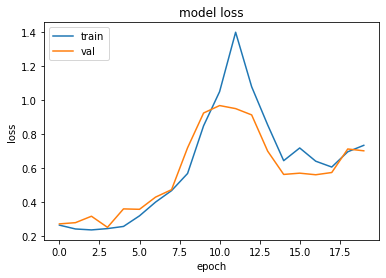

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
nn_kfold(df_sub_log)

Training data shape: (16807, 125)
Val data shape: (4202, 125)
Test data shape: (10348, 125)
Input shape: 124
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 124, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 123, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 123, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 122, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 122, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 121, 64)           4160      
__________

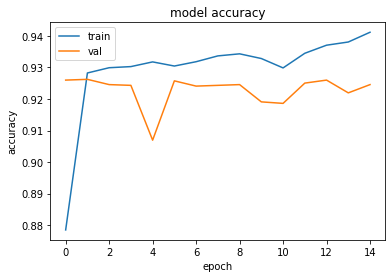

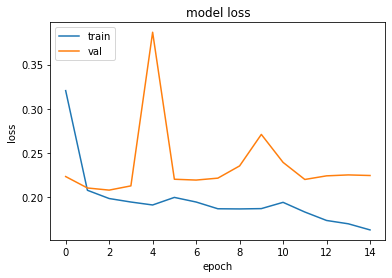

[[9390  191]
 [ 598  169]]
F1 score: 0.29991126885536823
Precision: 0.46944444444444444
Recall: 0.22033898305084745
Accuracy: 0.9237533822960958
ROC AUC: 0.6002018472294213


In [25]:
cnn(df_sub_log)

Training data shape: (16807, 125)
Val data shape: (4202, 125)
Test data shape: (10348, 125)
Input shape: 124
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 200)               25000     
_________________________________________________________________
dropout_101 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_102 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_103 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 216us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.1391885232647947;  accuracy of 0.7686705589294434; precision of 0.7686705589294434; recall of 0.7686705589294434; AUC of 0.809211790561676;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 227us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.4493951310213338;  accuracy of 0.6748536229133606; precision of 0.6748536229133606; recall of 0.6748536229133606; AUC of 0.711484968662262;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 213us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.8525222231281939;  accuracy of 0.7526774406433105; precision of 0.7526774406433105; recall of 0.7526774406433105; AUC of 0.8301043510437012;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


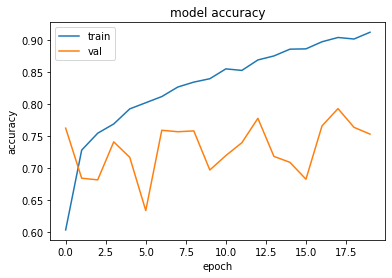

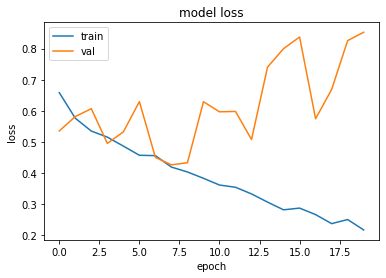

[[7175 2406]
 [ 234  533]]
F1 score: 0.2876416621694549
Precision: 0.18135420210956107
Recall: 0.6949152542372882
Accuracy: 0.7448782373405489
ROC AUC: 0.721896620960623


In [26]:
nn_kfold(df_sub_log, balanced_batches=True)

Training data shape: (16807, 125)
Val data shape: (4202, 125)
Test data shape: (10348, 125)
Input shape: 124
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 124, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 123, 32)           96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 123, 32)           128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 122, 32)           2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 122, 32)           128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 121, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/15
79/79 [==============================] - 33s 416ms/step - loss: 0.6856 - accuracy: 0.7112 - precision: 0.7112 - recall: 0.7112 - AUC: 0.7722 - val_loss: 0.5639 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250 - val_AUC: 0.9683
Epoch 2/15
79/79 [==============================] - 23s 296ms/step - loss: 0.5068 - accuracy: 0.7560 - precision: 0.7560 - recall: 0.7560 - AUC: 0.8343 - val_loss: 0.6720 - val_accuracy: 0.6278 - val_precision: 0.6278 - val_recall: 0.6278 - val_AUC: 0.6574
Epoch 3/15
79/79 [==============================] - 23s 295ms/step - loss: 0.4660 - accuracy: 0.7796 - precision: 0.7796 - recall: 0.7796 - AUC: 0.8590 - val_loss: 0.6854 - val_accuracy: 0.5657 - val_precision: 0.5657 - val_recall: 0.5657 - val_AUC: 0.5772
Epoch 4/15
79/79 [==============================] - 23s 295ms/step - loss: 0.4408 - accuracy: 0.7967 - precision: 0.7967 - recall: 0.7967 - AUC: 0.8750 - val_loss: 0.7047 - val_accuracy: 0.5750 - val_precision: 0.5750 - val_recal

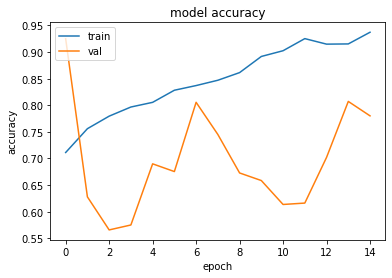

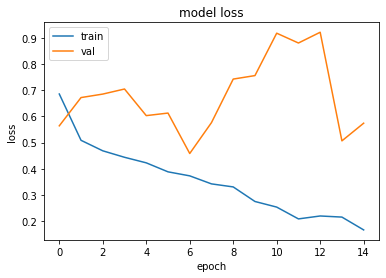

[[7624 1957]
 [ 305  462]]
F1 score: 0.2900188323917138
Precision: 0.190988011575031
Recall: 0.6023468057366362
Accuracy: 0.7814070351758794
ROC AUC: 0.6990441887988056


In [27]:
cnn(df_sub_log, balanced_batches=True)

## Subset + log + sqrt

In [28]:
df_sub_log_sqrt = df_sub_log.copy()

# cont, non_cont, cat_encode, = var_type(df_sub_log_sqrt)

# log of all cont columns
for var in cont:
    df_sub_log_sqrt[str(var) + '_sqrt'] = (df_sub_log_sqrt[var]-df_sub_log_sqrt[var].min()+1).transform(np.sqrt)


df_sub_log_sqrt.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,lab_VitD_sqrt,pulse_sqrt,BMI_sqrt,monthly_income_sqrt,lab_VitB12_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,5.745433,4.795832,4.326662,3.765132,24.791436,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,8.325263,5.196152,3.544009,3.765132,24.791436,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,6.140847,3.872983,4.295346,3.765132,24.791436,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,4.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,7.610273,5.744563,4.155719,3.765132,24.791436,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,4.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,6.527634,5.744563,3.223352,3.765132,24.791436,1.000000,2.645751,9.000000,1.162604,23.187734


Training data shape: (16807, 152)
Val data shape: (4202, 152)
Test data shape: (10348, 152)
Input shape: 151
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 200)               30400     
_________________________________________________________________
dropout_126 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_127 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_128 (Dropout)        (None, 100)               0         
__________

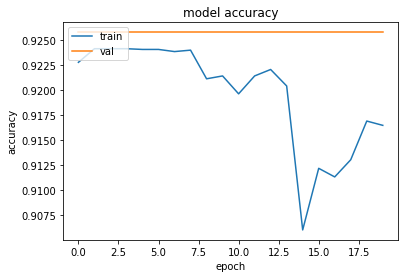

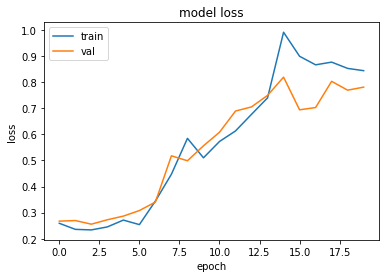

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
nn_kfold(df_sub_log_sqrt)

Training data shape: (16807, 152)
Val data shape: (4202, 152)
Test data shape: (10348, 152)
Input shape: 151
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 151, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 150, 32)           96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 150, 32)           128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 149, 32)           2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 149, 32)           128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 148, 64)           4160      
__________

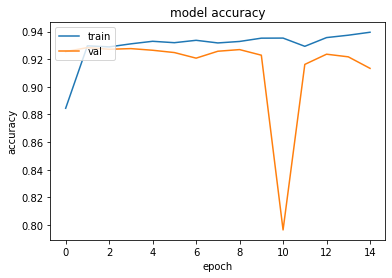

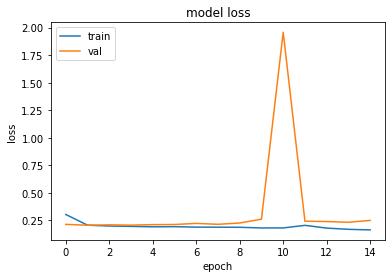

[[9267  314]
 [ 548  219]]
F1 score: 0.33692307692307694
Precision: 0.41088180112570355
Recall: 0.28552803129074317
Accuracy: 0.9166988790104368
ROC AUC: 0.6263774171692209


In [30]:
cnn(df_sub_log_sqrt)

Training data shape: (16807, 152)
Val data shape: (4202, 152)
Test data shape: (10348, 152)
Input shape: 151
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 200)               30400     
_________________________________________________________________
dropout_151 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_152 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_153 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 285us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.8623506089933903;  accuracy of 0.7159788608551025; precision of 0.7159788608551025; recall of 0.7159788608551025; AUC of 0.8233160972595215;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 236us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.8816237132685126;  accuracy of 0.7079823017120361; precision of 0.7079823017120361; recall of 0.7079823017120361; AUC of 0.7586647272109985;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 265us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.8219513409855739;  accuracy of 0.7031272053718567; precision of 0.7031272053718567; recall of 0.7031272053718567; AUC of 0.7539312243461609;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


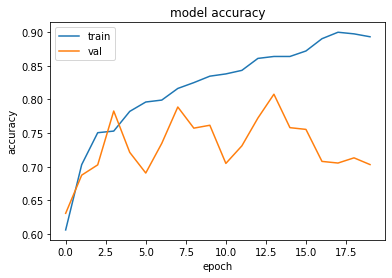

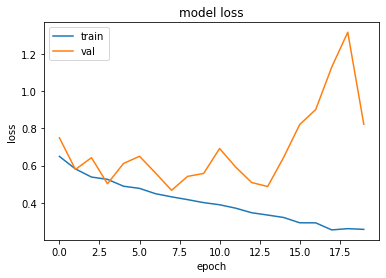

[[6501 3080]
 [ 202  565]]
F1 score: 0.25611967361740706
Precision: 0.1550068587105624
Recall: 0.7366362451108214
Accuracy: 0.6828372632392733
ROC AUC: 0.7075833349549515


In [31]:
nn_kfold(df_sub_log_sqrt, balanced_batches=True)

Training data shape: (16807, 152)
Val data shape: (4202, 152)
Test data shape: (10348, 152)
Input shape: 151
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 151, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 150, 32)           96        
_________________________________________________________________
batch_normalization_31 (Batc (None, 150, 32)           128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 149, 32)           2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 149, 32)           128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 148, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/15
79/79 [==============================] - 39s 498ms/step - loss: 0.7611 - accuracy: 0.7021 - precision: 0.7021 - recall: 0.7021 - AUC: 0.7573 - val_loss: 1.1911 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1155
Epoch 2/15
79/79 [==============================] - 28s 354ms/step - loss: 0.5283 - accuracy: 0.7480 - precision: 0.7480 - recall: 0.7480 - AUC: 0.8267 - val_loss: 1.0345 - val_accuracy: 0.0757 - val_precision: 0.0757 - val_recall: 0.0757 - val_AUC: 0.1165
Epoch 3/15
79/79 [==============================] - 28s 354ms/step - loss: 0.4738 - accuracy: 0.7768 - precision: 0.7768 - recall: 0.7768 - AUC: 0.8569 - val_loss: 1.0253 - val_accuracy: 0.1033 - val_precision: 0.1033 - val_recall: 0.1033 - val_AUC: 0.1205
Epoch 4/15
79/79 [==============================] - 28s 354ms/step - loss: 0.4186 - accuracy: 0.8099 - precision: 0.8099 - recall: 0.8099 - AUC: 0.8885 - val_loss: 0.9217 - val_accuracy: 0.2746 - val_precision: 0.2746 - val_recal

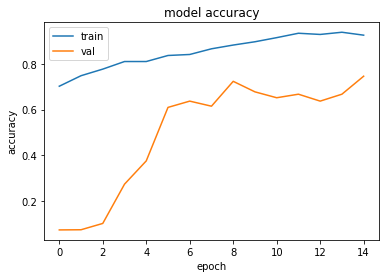

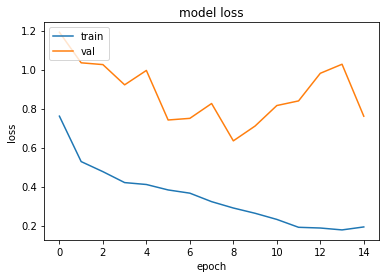

[[7195 2386]
 [ 252  515]]
F1 score: 0.28080697928026177
Precision: 0.17752499138228198
Recall: 0.6714471968709257
Accuracy: 0.7450715114031697
ROC AUC: 0.7112063246644577


In [32]:
cnn(df_sub_log_sqrt, balanced_batches=True)

## All created + cubed

In [33]:
df_created_cubed = df_ext_square.copy()

# cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_cubed[str(var) + '_cubed'] = np.power((df_created_cubed[var]),3)


df_created_cubed.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,lab_VitD_cubed,pulse_cubed,BMI_cubed,monthly_income_cubed,lab_VitB12_cubed,#_chronic_condition_cubed,hours_screen_cubed,combined_BP_cubed,people_per_rooms_cubed,diet_tot_VitB_cubed
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,52734.375000,195112.0,29503.629000,2848.927967,2.519753e+08,1.0,8.0,10360232.0,0.125000,2.711221e+07
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,401947.272000,238328.0,15142.552424,2848.927967,2.519753e+08,8.0,8.0,7762392.0,0.015625,5.401924e+08
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,75151.448000,125000.0,28736.971047,2848.927967,2.519753e+08,1.0,1.0,7762392.0,0.023324,2.404323e+07
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,243043.705234,314432.0,25542.058625,2848.927967,2.519753e+08,8.0,512.0,5268024.0,0.052734,2.934009e+07
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,104487.111000,314432.0,11497.268593,2848.927967,2.519753e+08,0.0,216.0,4913000.0,0.078717,1.545697e+08


In [34]:
#nn_kfold(df_created_cubed)

Training data shape: (16807, 203)
Val data shape: (4202, 203)
Test data shape: (10348, 203)
Input shape: 202
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 202, 1)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 201, 32)           96        
_________________________________________________________________
batch_normalization_36 (Batc (None, 201, 32)           128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 200, 32)           2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 200, 32)           128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 199, 64)           4160      
__________

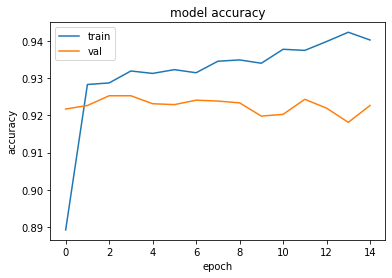

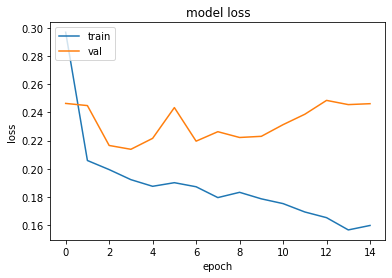

[[9453  128]
 [ 663  104]]
F1 score: 0.20820820820820823
Precision: 0.4482758620689655
Recall: 0.13559322033898305
Accuracy: 0.9235601082334751
ROC AUC: 0.5611167228925894


In [35]:
cnn(df_created_cubed)

In [36]:
#nn_kfold(df_created_cubed, balanced_batches=True)

In [37]:
#cnn(df_created_cubed, balanced_batches=True)

## All created + squared continous columns

In [38]:
df_raw_mean_75_ext.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_2,monthly_income_2,min_sedetary_2,lab_VitB12_2,bone_mineral_density_2,#_chronic_condition_2,hours_screen_2,combined_BP_2,people_per_rooms_2,diet_tot_VitB_2
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,12.3958,816.761666,169166.2905,797666.28455,1.249052,1.0,4.0,47524.0,0.250000,90249.172225
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,12.3958,816.761666,169166.2905,797666.28455,1.249052,4.0,4.0,39204.0,0.062500,663283.194084
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,12.3958,816.761666,169166.2905,797666.28455,1.249052,1.0,1.0,39204.0,0.081633,83303.236129
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,12.3958,816.761666,169166.2905,797666.28455,1.249052,4.0,64.0,30276.0,0.140625,95127.831184
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,12.3958,816.761666,169166.2905,797666.28455,1.249052,0.0,36.0,28900.0,0.183673,288015.762241


Training data shape: (16807, 226)
Val data shape: (4202, 226)
Test data shape: (10348, 226)
Input shape: 225
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               45200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

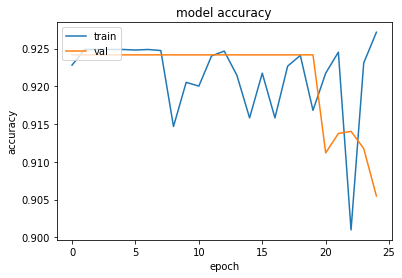

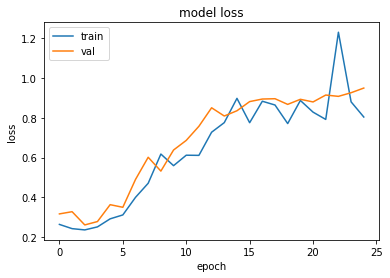

[[9237  344]
 [ 628  139]]
F1 score: 0.22240000000000001
Precision: 0.28778467908902694
Recall: 0.18122555410691005
Accuracy: 0.906068805566293
ROC AUC: 0.5726605799967803


In [18]:
nn_kfold(df_raw_mean_75_ext)

Training data shape: (16807, 226)
Val data shape: (4202, 226)
Test data shape: (10348, 226)
Input shape: 225
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 225, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 224, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 223, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 223, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 222, 64)           4160      
___________

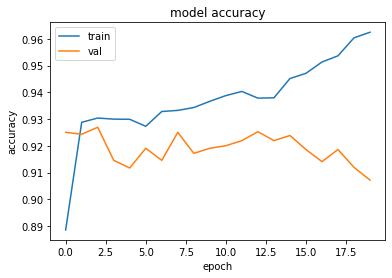

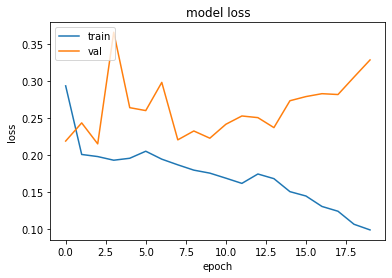

[[9104  477]
 [ 535  232]]
F1 score: 0.3143631436314363
Precision: 0.32722143864598024
Recall: 0.30247718383311606
Accuracy: 0.9022033243138771
ROC AUC: 0.6263455744862272


In [19]:
cnn(df_raw_mean_75_ext)

Training data shape: (16807, 226)
Val data shape: (4202, 226)
Test data shape: (10348, 226)
Input shape: 225
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               45200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 178us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.485236308242055;  accuracy of 0.6751392483711243; precision of 0.6751392483711243; recall of 0.6751392483711243; AUC of 0.7086089253425598;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 187us/step
------------------------------------------------------------------------
Score for fold 2: loss of 2.5622883741811022;  accuracy of 0.7232614755630493; precision of 0.7232614755630493; recall of 0.7232614755630493; AUC of 0.7388955950737;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 191us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.1598334751622126;  accuracy of 0.7542482018470764; precision of 0.7542482018470764; recall of 0.7542482018470764; AUC of 0.8063921332359314;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


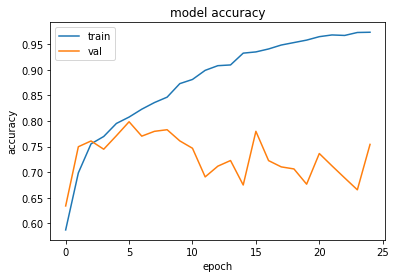

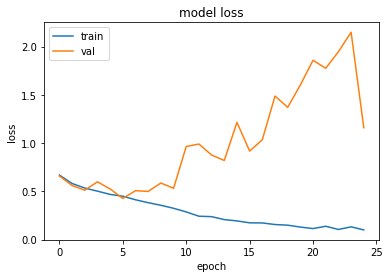

[[7153 2428]
 [ 222  545]]
F1 score: 0.2914438502673797
Precision: 0.18331651530440632
Recall: 0.7105606258148631
Accuracy: 0.7439118670274449
ROC AUC: 0.7285712011236929


In [20]:
nn_kfold(df_raw_mean_75_ext, balanced_batches=True)

Training data shape: (16807, 226)
Val data shape: (4202, 226)
Test data shape: (10348, 226)
Input shape: 225
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 225, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 224, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 223, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 223, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 222, 64)           4160      
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 51s 644ms/step - loss: 0.6791 - accuracy: 0.7009 - precision: 0.7009 - recall: 0.7009 - AUC: 0.7646 - val_loss: 0.7690 - val_accuracy: 0.0764 - val_precision: 0.0764 - val_recall: 0.0764 - val_AUC: 0.1180
Epoch 2/20
79/79 [==============================] - 42s 534ms/step - loss: 0.5064 - accuracy: 0.7680 - precision: 0.7680 - recall: 0.7680 - AUC: 0.8391 - val_loss: 0.8236 - val_accuracy: 0.0826 - val_precision: 0.0826 - val_recall: 0.0826 - val_AUC: 0.1185
Epoch 3/20
79/79 [==============================] - 42s 530ms/step - loss: 0.4490 - accuracy: 0.7963 - precision: 0.7963 - recall: 0.7963 - AUC: 0.8712 - val_loss: 0.6756 - val_accuracy: 0.5945 - val_precision: 0.5945 - val_recall: 0.5945 - val_AUC: 0.6191
Epoch 4/20
79/79 [==============================] - 40s 510ms/step - loss: 0.4134 - accuracy: 0.8059 - precision: 0.8059 - recall: 0.8059 - AUC: 0.8921 - val_loss: 0.5475 - val_accuracy: 0.7763 - val_precision: 0.7763 - val_recal

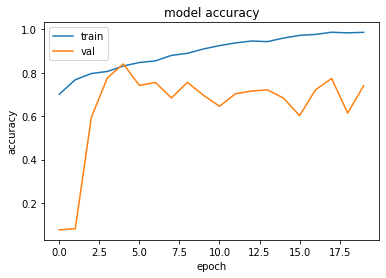

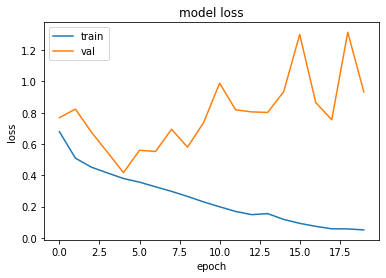

[[7180 2401]
 [ 261  506]]
F1 score: 0.2754491017964072
Precision: 0.17406260749914002
Recall: 0.6597131681877445
Accuracy: 0.7427522226517201
ROC AUC: 0.7045565110326052


In [21]:
cnn(df_raw_mean_75_ext, balanced_batches=True)

## + log(n)

In [39]:
df_add_log = df_raw_mean_75_ext.copy()

cont, non_cont, cat_encode, = var_type(df_add_log)

# remove squared values from continous var list
og_cont = []
for i in range(len(cont)):
    if cont[i].endswith('_2') == False:
        og_cont.append(cont[i])

# log of all cont columns
for var in og_cont:
    df_add_log[str(var) + '_log'] = (df_add_log[var]-df_add_log[var].min()+1).transform(np.log)


df_add_log.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_log,monthly_income_log,min_sedetary_log,lab_VitB12_log,bone_mineral_density_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,0.693147,1.098612,4.859812,0.352821,5.708488
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,1.098612,1.098612,4.691348,0.159630,6.703706
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,0.693147,0.693147,4.691348,0.189621,5.668580
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,1.098612,2.197225,4.442651,0.260884,5.734725
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,1.130338,2.651566,5.883571,6.420997,0.321423,0.000000,1.945910,4.394449,0.301325,6.287247


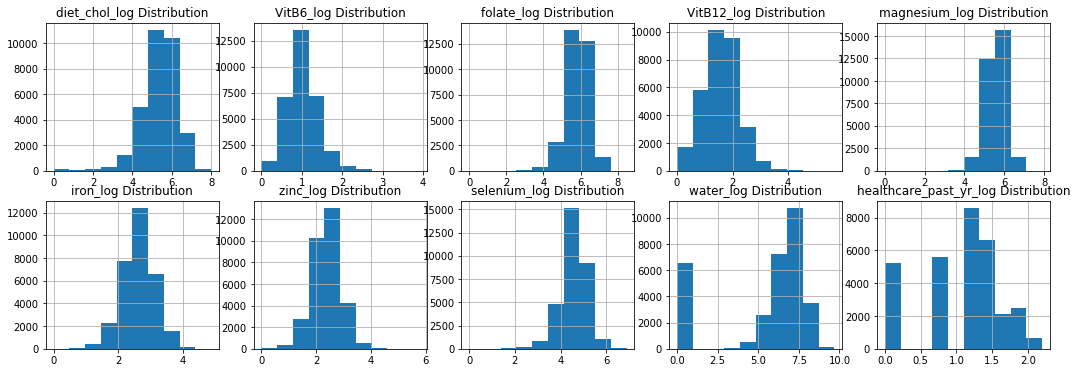

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,6))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    #fig.tight_layout()  # Improves appearance a bit.
    plt.show()

check = ['diet_chol_log',
 'VitB6_log',
 'folate_log',
 'VitB12_log',
 'magnesium_log',
 'iron_log',
 'zinc_log',
 'selenium_log',
 'water_log',
 'healthcare_past_yr_log']

draw_histograms(df_add_log, check, 2, 5)

Training data shape: (16807, 275)
Val data shape: (4202, 275)
Test data shape: (10348, 275)
Input shape: 274
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               55000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

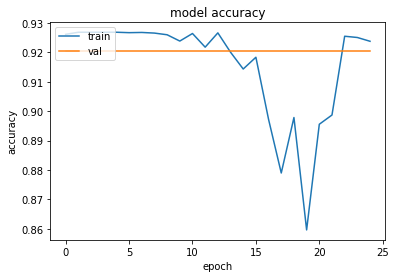

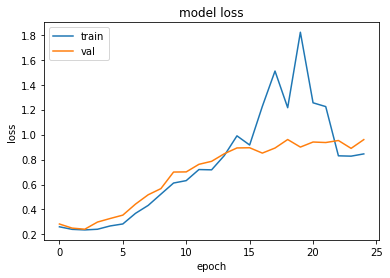

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
nn_kfold(df_add_log)

Training data shape: (16807, 275)
Val data shape: (4202, 275)
Test data shape: (10348, 275)
Input shape: 274
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 274, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 273, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 273, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 272, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 272, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 271, 64)           4160      
___________

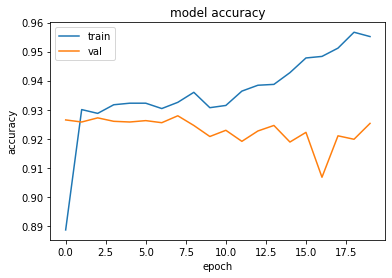

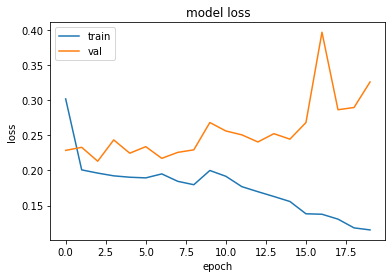

[[9426  155]
 [ 649  118]]
F1 score: 0.22692307692307695
Precision: 0.43223443223443225
Recall: 0.15384615384615385
Accuracy: 0.9223038268264399
ROC AUC: 0.5688341509237032


In [17]:
cnn(df_add_log)

Training data shape: (16807, 275)
Val data shape: (4202, 275)
Test data shape: (10348, 275)
Input shape: 274
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               55000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 195us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.4183109215152583;  accuracy of 0.7066971063613892; precision of 0.7066971063613892; recall of 0.7066971063613892; AUC of 0.7382324934005737;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 189us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.9268597612444986;  accuracy of 0.7336855530738831; precision of 0.7336855530738831; recall of 0.7336855530738831; AUC of 0.8028599619865417;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 207us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.3987448421287891;  accuracy of 0.7498214840888977; precision of 0.7498214840888977; recall of 0.7498214840888977; AUC of 0.8043767213821411;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


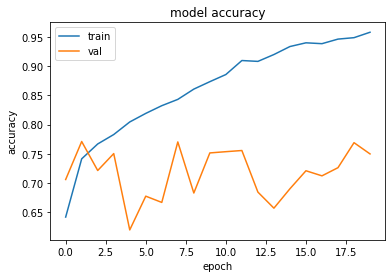

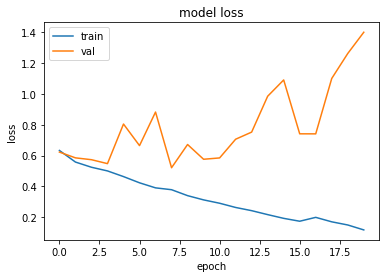

[[7079 2502]
 [ 236  531]]
F1 score: 0.2794736842105263
Precision: 0.17507418397626112
Recall: 0.6923076923076923
Accuracy: 0.7354078082721299
ROC AUC: 0.7155829245381484


In [18]:
EPOCHS_1=20
nn_kfold(df_add_log, balanced_batches=True)

Training data shape: (16807, 275)
Val data shape: (4202, 275)
Test data shape: (10348, 275)
Input shape: 274
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 274, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 273, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 273, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 272, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 272, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 271, 64)           4160      
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/10
79/79 [==============================] - 58s 739ms/step - loss: 0.7716 - accuracy: 0.6946 - precision: 0.6946 - recall: 0.6946 - AUC: 0.7508 - val_loss: 1.2331 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1100
Epoch 2/10
79/79 [==============================] - 48s 613ms/step - loss: 0.5153 - accuracy: 0.7724 - precision: 0.7724 - recall: 0.7724 - AUC: 0.8399 - val_loss: 0.9954 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1122
Epoch 3/10
79/79 [==============================] - 48s 610ms/step - loss: 0.4522 - accuracy: 0.7971 - precision: 0.7971 - recall: 0.7971 - AUC: 0.8721 - val_loss: 0.8196 - val_accuracy: 0.3046 - val_precision: 0.3046 - val_recall: 0.3046 - val_AUC: 0.2530
Epoch 4/10
79/79 [==============================] - 49s 620ms/step - loss: 0.4042 - accuracy: 0.8143 - precision: 0.8143 - recall: 0.8143 - AUC: 0.8964 - val_loss: 0.6119 - val_accuracy: 0.6942 - val_precision: 0.6942 - val_recal

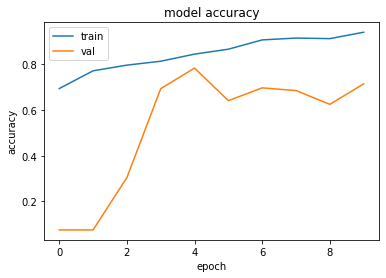

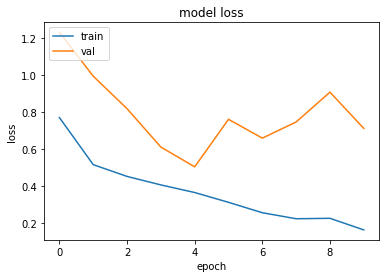

[[6907 2674]
 [ 269  498]]
F1 score: 0.25285605483625284
Precision: 0.15699873896595207
Recall: 0.6492829204693612
Accuracy: 0.7155972168534983
ROC AUC: 0.6850944400906455


In [19]:
EPOCHS_2 = 10
cnn(df_add_log, balanced_batches=True)

## + square root

In [40]:
df_add_sqrt = df_add_log.copy()

# original continuous variables is og_cont

# log of all cont columns
for var in og_cont:
    df_add_sqrt[str(var) + '_sqrt'] = (df_add_sqrt[var]-df_add_sqrt[var].min()+1).transform(np.sqrt)


df_add_sqrt.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_sqrt,monthly_income_sqrt,min_sedetary_sqrt,lab_VitB12_sqrt,bone_mineral_density_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,1.759745,3.765132,18.949655,24.791436,1.174346,1.000000,2.645751,9.000000,1.162604,23.187734


Training data shape: (16807, 324)
Val data shape: (4202, 324)
Test data shape: (10348, 324)
Input shape: 323
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 200)               64800     
_________________________________________________________________
dropout_177 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_207 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_178 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_208 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_179 (Dropout)        (None, 100)               0         
__________

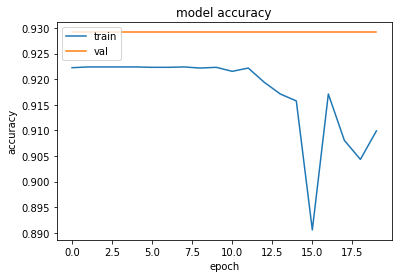

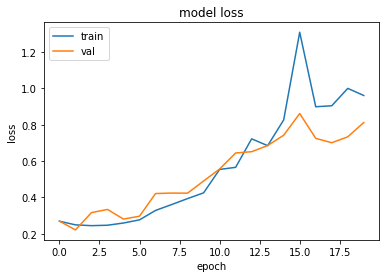

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
EPOCHS_1=20
nn_kfold(df_add_sqrt)

Training data shape: (16807, 324)
Val data shape: (4202, 324)
Test data shape: (10348, 324)
Input shape: 323
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 323, 1)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 322, 32)           96        
_________________________________________________________________
batch_normalization_41 (Batc (None, 322, 32)           128       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 321, 32)           2080      
_________________________________________________________________
batch_normalization_42 (Batc (None, 321, 32)           128       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 320, 64)           4160      
__________

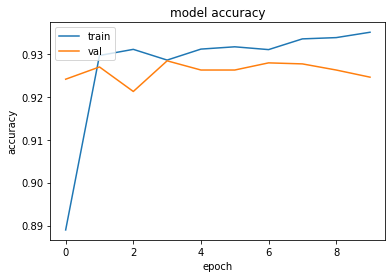

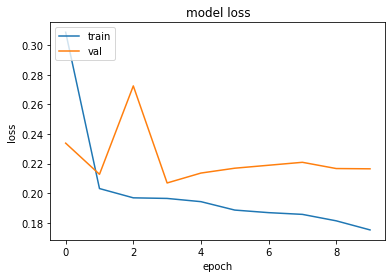

[[9435  146]
 [ 624  143]]
F1 score: 0.2708333333333333
Precision: 0.49480968858131485
Recall: 0.1864406779661017
Accuracy: 0.9255894858909934
ROC AUC: 0.5856010925578343


In [42]:
EPOCHS_2 = 10
cnn(df_add_sqrt)

Training data shape: (16807, 324)
Val data shape: (4202, 324)
Test data shape: (10348, 324)
Input shape: 323
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 200)               64800     
_________________________________________________________________
dropout_202 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_236 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_203 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_237 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_204 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 272us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.5126449436387657;  accuracy of 0.7112665772438049; precision of 0.7112665772438049; recall of 0.7112665772438049; AUC of 0.7416704297065735;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 275us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.0566258690586332;  accuracy of 0.7511066794395447; precision of 0.7511066794395447; recall of 0.7511066794395447; AUC of 0.7872025966644287;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 271us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.603667428097554;  accuracy of 0.7541053891181946; precision of 0.7541053891181946; recall of 0.7541053891181946; AUC of 0.7958285808563232;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


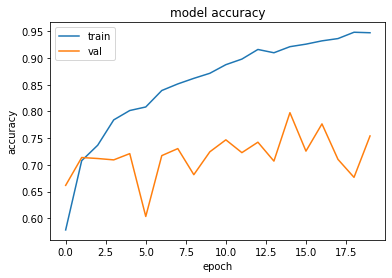

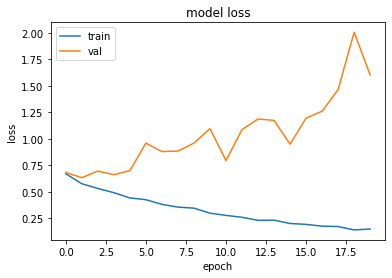

[[7151 2430]
 [ 254  513]]
F1 score: 0.2765498652291105
Precision: 0.1743119266055046
Recall: 0.6688396349413298
Accuracy: 0.7406262079628914
ROC AUC: 0.7076063324482247


In [43]:
nn_kfold(df_add_sqrt, balanced_batches=True)

Training data shape: (16807, 324)
Val data shape: (4202, 324)
Test data shape: (10348, 324)
Input shape: 323
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 323, 1)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 322, 32)           96        
_________________________________________________________________
batch_normalization_46 (Batc (None, 322, 32)           128       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 321, 32)           2080      
_________________________________________________________________
batch_normalization_47 (Batc (None, 321, 32)           128       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 320, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/10
79/79 [==============================] - 71s 900ms/step - loss: 0.7655 - accuracy: 0.6998 - precision: 0.6998 - recall: 0.6998 - AUC: 0.7530 - val_loss: 0.5056 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250 - val_AUC: 0.9665
Epoch 2/10
79/79 [==============================] - 57s 718ms/step - loss: 0.5193 - accuracy: 0.7544 - precision: 0.7544 - recall: 0.7544 - AUC: 0.8326 - val_loss: 0.7096 - val_accuracy: 0.4474 - val_precision: 0.4474 - val_recall: 0.4474 - val_AUC: 0.4252
Epoch 3/10
79/79 [==============================] - 57s 722ms/step - loss: 0.4756 - accuracy: 0.7740 - precision: 0.7740 - recall: 0.7740 - AUC: 0.8547 - val_loss: 0.6391 - val_accuracy: 0.7247 - val_precision: 0.7247 - val_recall: 0.7247 - val_AUC: 0.7857
Epoch 4/10
79/79 [==============================] - 57s 716ms/step - loss: 0.4248 - accuracy: 0.8071 - precision: 0.8071 - recall: 0.8071 - AUC: 0.8847 - val_loss: 0.5668 - val_accuracy: 0.7699 - val_precision: 0.7699 - val_recal

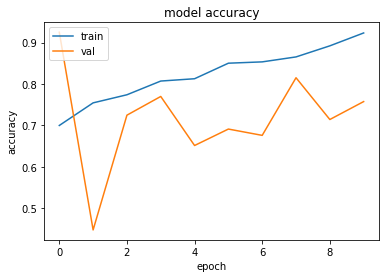

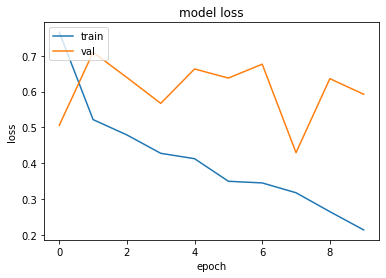

[[7290 2291]
 [ 290  477]]
F1 score: 0.2698727015558699
Precision: 0.17232658959537572
Recall: 0.621903520208605
Accuracy: 0.7505798221878623
ROC AUC: 0.6913922151716232


In [44]:
cnn(df_add_sqrt, balanced_batches=True)

## + polynomial

In [45]:
df_add_poly = df_add_sqrt.copy()

# original continuous variables is og_cont

# 1+5x+8x2
for var in og_cont:
    df_add_poly[str(var) + '_poly'] = (1+(5*df_add_poly[var])+(8*np.power(df_add_poly[var],2)))


df_add_poly.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_poly,monthly_income_poly,min_sedetary_poly,lab_VitB12_poly,bone_mineral_density_poly,#_chronic_condition_poly,hours_screen_poly,combined_BP_poly,people_per_rooms_poly,diet_tot_VitB_poly
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,14.0,43.0,381283.0,5.500000,7.234965e+05
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,43.0,43.0,314623.0,2.750000,5.310339e+06
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,14.0,14.0,314623.0,3.081633,6.678700e+05
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,43.0,553.0,243079.0,4.000000,7.625658e+05
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,46.652834,1679.603149,1.027616e+06,3.194662e+06,16.454389,1.0,319.0,232051.0,4.612245,2.306810e+06


Training data shape: (16807, 373)
Val data shape: (4202, 373)
Test data shape: (10348, 373)
Input shape: 372
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_264 (Dense)            (None, 200)               74600     
_________________________________________________________________
dropout_227 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_265 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_228 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_266 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_229 (Dropout)        (None, 100)               0         
__________

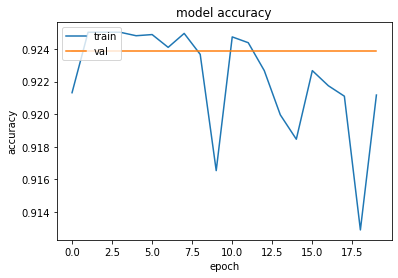

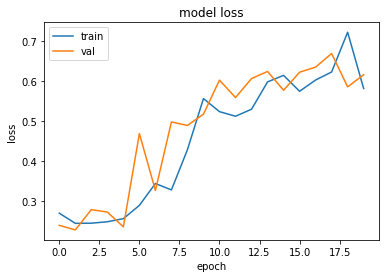

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
nn_kfold(df_add_poly)

Training data shape: (16807, 373)
Val data shape: (4202, 373)
Test data shape: (10348, 373)
Input shape: 372
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 372, 1)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 371, 32)           96        
_________________________________________________________________
batch_normalization_51 (Batc (None, 371, 32)           128       
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 370, 32)           2080      
_________________________________________________________________
batch_normalization_52 (Batc (None, 370, 32)           128       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 369, 64)           4160      
__________

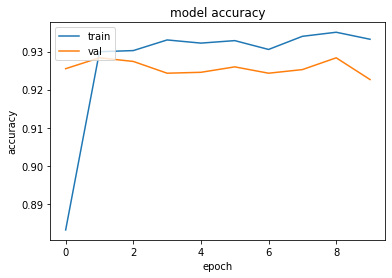

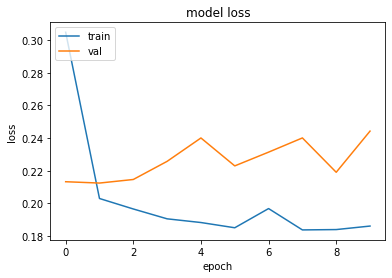

[[9402  179]
 [ 632  135]]
F1 score: 0.24976873265494917
Precision: 0.4299363057324841
Recall: 0.1760104302477184
Accuracy: 0.9216273676072672
ROC AUC: 0.5786638102600663


In [47]:
cnn(df_add_poly)

Training data shape: (16807, 373)
Val data shape: (4202, 373)
Test data shape: (10348, 373)
Input shape: 372
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_293 (Dense)            (None, 200)               74600     
_________________________________________________________________
dropout_252 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_294 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_253 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_295 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_254 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 3s 416us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.0229126180765646;  accuracy of 0.7345423102378845; precision of 0.7345423102378845; recall of 0.7345423102378845; AUC of 0.7942194938659668;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 324us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.1350784967171368;  accuracy of 0.7148364782333374; precision of 0.7148364782333374; recall of 0.7148364782333374; AUC of 0.7535011768341064;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 291us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.8861740181552636;  accuracy of 0.7096958160400391; precision of 0.7096958160400391; recall of 0.7096958160400391; AUC of 0.75921231508255;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


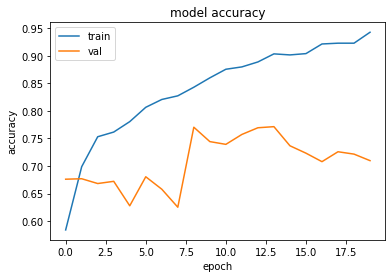

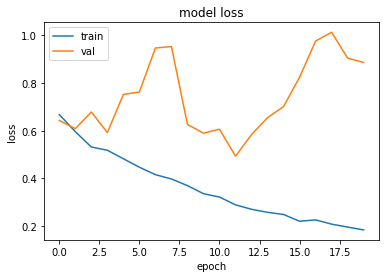

[[6656 2925]
 [ 215  552]]
F1 score: 0.2601319509896324
Precision: 0.15875754961173424
Recall: 0.7196870925684485
Accuracy: 0.6965597216853499
ROC AUC: 0.7071976846831387


In [48]:
nn_kfold(df_add_poly, balanced_batches=True)

Training data shape: (16807, 373)
Val data shape: (4202, 373)
Test data shape: (10348, 373)
Input shape: 372
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 372, 1)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 371, 32)           96        
_________________________________________________________________
batch_normalization_56 (Batc (None, 371, 32)           128       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 370, 32)           2080      
_________________________________________________________________
batch_normalization_57 (Batc (None, 370, 32)           128       
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 369, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/10
79/79 [==============================] - 76s 959ms/step - loss: 0.8117 - accuracy: 0.6792 - precision: 0.6792 - recall: 0.6792 - AUC: 0.7397 - val_loss: 0.3163 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250 - val_AUC: 0.9655
Epoch 2/10
79/79 [==============================] - 65s 825ms/step - loss: 0.5295 - accuracy: 0.7432 - precision: 0.7432 - recall: 0.7432 - AUC: 0.8236 - val_loss: 0.2606 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250 - val_AUC: 0.9647
Epoch 3/10
79/79 [==============================] - 67s 846ms/step - loss: 0.4590 - accuracy: 0.7879 - precision: 0.7879 - recall: 0.7879 - AUC: 0.8658 - val_loss: 0.2683 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250 - val_AUC: 0.9649
Epoch 4/10
79/79 [==============================] - 65s 827ms/step - loss: 0.4198 - accuracy: 0.8023 - precision: 0.8023 - recall: 0.8023 - AUC: 0.8881 - val_loss: 0.2621 - val_accuracy: 0.9246 - val_precision: 0.9246 - val_recal

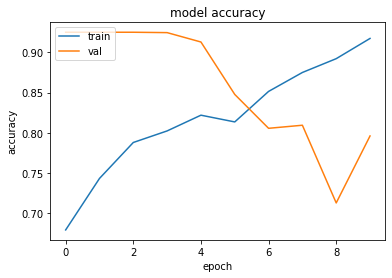

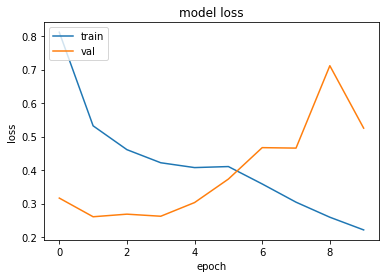

[[7718 1863]
 [ 328  439]]
F1 score: 0.2860866731834474
Precision: 0.1907037358818419
Recall: 0.5723598435462842
Accuracy: 0.7882682643989176
ROC AUC: 0.6889562499226045


In [49]:
cnn(df_add_poly, balanced_batches=True)

## + sin(n)

In [50]:
df_add_sin = df_add_poly.copy()

# original continuous variables is og_cont

# log of all cont columns
for var in og_cont:
    df_add_sin[str(var) + '_sin'] = (df_add_sin[var]-df_add_sin[var].min()+1).transform(np.sin)


df_add_sin.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_sin,monthly_income_sin,min_sedetary_sin,lab_VitB12_sin,bone_mineral_density_sin,#_chronic_condition_sin,hours_screen_sin,combined_BP_sin,people_per_rooms_sin,diet_tot_VitB_sin
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.909297,0.141120,-0.193473,0.989109,-0.176958
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.141120,0.141120,0.816743,0.921947,-0.984074
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.562688,1.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.909297,0.909297,0.816743,0.935189,0.561730
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.141120,0.412118,-0.176076,0.963042,0.999822
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,0.044874,0.999237,0.812174,-0.907313,0.98168,0.841471,0.656987,-0.629888,0.976083,-0.442744


Training data shape: (16807, 422)
Val data shape: (4202, 422)
Test data shape: (10348, 422)
Input shape: 421
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_322 (Dense)            (None, 200)               84400     
_________________________________________________________________
dropout_277 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_323 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_278 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_324 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_279 (Dropout)        (None, 100)               0         
__________

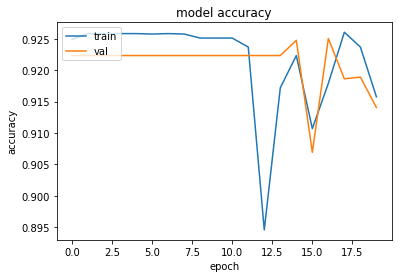

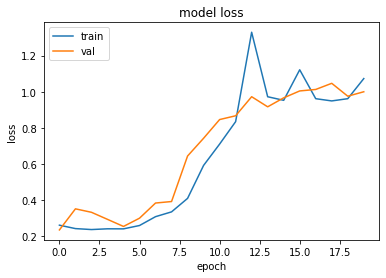

[[9362  219]
 [ 666  101]]
F1 score: 0.1858325666973321
Precision: 0.315625
Recall: 0.1316818774445893
Accuracy: 0.9144762272902976
ROC AUC: 0.5544120690844698


In [51]:
nn_kfold(df_add_sin)

Training data shape: (16807, 422)
Val data shape: (4202, 422)
Test data shape: (10348, 422)
Input shape: 421
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 421, 1)            0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 420, 32)           96        
_________________________________________________________________
batch_normalization_61 (Batc (None, 420, 32)           128       
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 419, 32)           2080      
_________________________________________________________________
batch_normalization_62 (Batc (None, 419, 32)           128       
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 418, 64)           4160      
__________

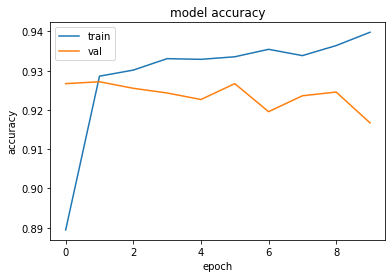

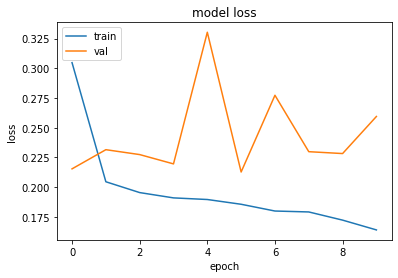

[[9297  284]
 [ 574  193]]
F1 score: 0.3102893890675241
Precision: 0.40461215932914046
Recall: 0.2516297262059974
Accuracy: 0.9170854271356784
ROC AUC: 0.6109938632073719


In [52]:
cnn(df_add_sin)

Training data shape: (16807, 422)
Val data shape: (4202, 422)
Test data shape: (10348, 422)
Input shape: 421
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_351 (Dense)            (None, 200)               84400     
_________________________________________________________________
dropout_302 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_352 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_303 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_353 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_304 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 311us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.6089586110586918;  accuracy of 0.6588605046272278; precision of 0.6588605046272278; recall of 0.6588605046272278; AUC of 0.733657956123352;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 326us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.340763176983805;  accuracy of 0.7461088299751282; precision of 0.7461088299751282; recall of 0.7461088299751282; AUC of 0.8166505098342896;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 350us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.1565650584237093;  accuracy of 0.7533913850784302; precision of 0.7533913850784302; recall of 0.7533913850784302; AUC of 0.8014678955078125;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


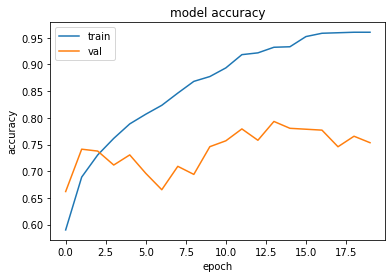

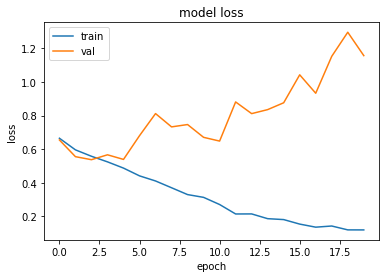

[[7157 2424]
 [ 272  495]]
F1 score: 0.2685838307107976
Precision: 0.1695786228160329
Recall: 0.6453715775749674
Accuracy: 0.7394665635871666
ROC AUC: 0.6961854234811482


In [53]:
nn_kfold(df_add_sin, balanced_batches=True)

Training data shape: (16807, 422)
Val data shape: (4202, 422)
Test data shape: (10348, 422)
Input shape: 421
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 421, 1)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 420, 32)           96        
_________________________________________________________________
batch_normalization_66 (Batc (None, 420, 32)           128       
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 419, 32)           2080      
_________________________________________________________________
batch_normalization_67 (Batc (None, 419, 32)           128       
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 418, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/10
79/79 [==============================] - 84s 1s/step - loss: 0.7580 - accuracy: 0.6930 - precision: 0.6930 - recall: 0.6930 - AUC: 0.7480 - val_loss: 0.9965 - val_accuracy: 0.0752 - val_precision: 0.0752 - val_recall: 0.0752 - val_AUC: 0.1075
Epoch 2/10
79/79 [==============================] - 73s 928ms/step - loss: 0.5191 - accuracy: 0.7608 - precision: 0.7608 - recall: 0.7608 - AUC: 0.8326 - val_loss: 1.0462 - val_accuracy: 0.0769 - val_precision: 0.0769 - val_recall: 0.0769 - val_AUC: 0.1122
Epoch 3/10
79/79 [==============================] - 73s 922ms/step - loss: 0.4468 - accuracy: 0.7923 - precision: 0.7923 - recall: 0.7923 - AUC: 0.8717 - val_loss: 1.0325 - val_accuracy: 0.0831 - val_precision: 0.0831 - val_recall: 0.0831 - val_AUC: 0.1128
Epoch 4/10
79/79 [==============================] - 73s 930ms/step - loss: 0.3984 - accuracy: 0.8235 - precision: 0.8235 - recall: 0.8235 - AUC: 0.9000 - val_loss: 0.9045 - val_accuracy: 0.3132 - val_precision: 0.3132 - val_recall: 

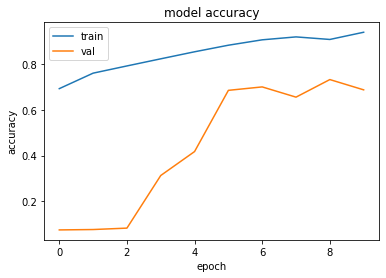

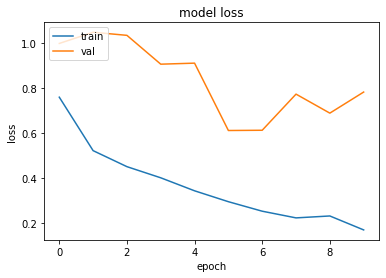

[[6509 3072]
 [ 232  535]]
F1 score: 0.24462734339277548
Precision: 0.1483227058497366
Recall: 0.6975228161668839
Accuracy: 0.6807112485504445
ROC AUC: 0.6884441134377891


In [54]:
cnn(df_add_sin, balanced_batches=True)